In [ ]:
import requests
import json
import ollama

url = "http://127.0.0.1:8000/query"
headers = {"Content-Type": "application/json"}
ollama.pull('llama3.1:8b') 

ProgressResponse(status='success', completed=None, total=None, digest=None)

## Get Answer of a Question ##

In [58]:
def get_response(query):
    response = requests.post(url, data=json.dumps({"query": query}), headers=headers)
    return response.json()

In [ ]:
def get_prompt(response):
    system_prompt = "You are a factual question-answering assistant specializing in information about Pittsburgh and Carnegie Mellon University (CMU).\nYour task is to provide accurate answers to questions about various facts concerning Pittsburgh and CMU.\nYou are given a user question and a context. Your task is to answer the question based on the retrieved documents in the context while also considering the chat history.\nDo not hallucinate or add extra information. Stick to the information provided in the retrieved documents.\nIf the retrieved documents do not contain information relevant to the question or if the information is irrelevant, then you shoud acknowledge that you don't have enough information to answer accurately.\nWrite in a clear, concise, and informative tone.\nDO not mention the source from where you got the information. If you get too much information, only use the information that you need to answer the question and ignore the rest."
    prompt = f"SYSTEM PROMPT:\n {system_prompt}\n ---------------------------\n"
    prompt += f"USER QUESTION:\n{response['query']}\n---------------------------\n"
    prompt += f"RETRIEVED DOCUMENTS:\n{response['context']}\n"
    prompt += f"---------------------------\nYour answer:"

    return prompt

def call_ollama(prompt):
    response = ollama.chat(model='llama3.1:8b', messages=[{"role": "user", "content": prompt}])
    return response.message.content

def get_answer(question):
    response = get_response(question)

    prompt = get_prompt(response)

    response = ollama.chat(model='llama3.1:8b', messages=[{"role": "user", "content": prompt}])

    return response.message.content

### Testings ###

In [ ]:
question = "How many spinoff companies did CMU create in 2014?  "
print(get_answer(question))

CMU created 36 spinoff companies in 2014.


In [44]:
question = "How many spinoff companies did CMU create in 2014?  "
print(get_answer(question))

RAG Response
{'query': 'How many spinoff companies did CMU create in 2014?  ', 'context': '39707: How many spinoff companies did CMU create in 2014?  \nA: 36.\n\n39688: How many companies have been launched from CMU?  \nA: Over 1,000 companies globally.\n\n39706: What major companies have set up operations in Pittsburgh due to CMU?  \nA: Google, Intel, Uber, and GE.'}
CMU created 36 spinoff companies in 2014.


## Evaluation Code ##

In [ ]:
import nltk
from nltk.corpus import stopwords
import string


nltk.download('stopwords')
print(stopwords.words('english'))
stop_words = set(stopwords.words('english'))

In [48]:
def remove_stop_words(text, stopwords):
    words = text.translate(str.maketrans('', '', string.punctuation)).split()

    word_set = set()

    for w in words:
        if w not in stopwords:
            word_set.add(w)
    
    return word_set


def get_confusion_matrix(gt, answer, stopwords):
    gt_set = remove_stop_words(gt, stopwords)
    answer_set = remove_stop_words(answer, stopwords)

    intersect = gt_set.intersection(answer_set)
    false_negative = gt_set - answer_set
    false_positive = answer_set - gt_set

    return len(intersect), len(false_negative), len(false_positive)

def calculate_metrics(gt, answer, stopwords):
    TP, FN, FP =  get_confusion_matrix(gt, answer, stopwords)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fnr = FN / (TP + FN) if (TP + FN) > 0 else 0
    
    return {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score,
        "False Negative Rate": fnr,
        "TP": TP,
        "FN": FN,
        "FP": FP
    }

In [47]:
def get_semantic_similarity(gt, answer, model):
    # Get sentence embeddings
    embedding1 = model.encode(gt, convert_to_tensor=True)
    embedding2 = model.encode(answer, convert_to_tensor=True)

    # Compute cosine similarity
    similarity = util.cos_sim(embedding1, embedding2)

    return similarity

In [ ]:
from sentence_transformers import SentenceTransformer, util


text = "I like that good apple, do you like it?"
gt = "I love apple, it is good"

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

## Evaluate ##

In [60]:
def load_QAs(file_dir):

    with open(file_dir, 'r') as f:
        data = f.readlines()
    
    num_lines = len(data)

    QA_pairs = []

    for i in range(num_lines//3):
        q = data[i*3].replace("Q: ", "")
        a = data[i*3+1].replace("A: ", "")

        QA_pairs.append((q,a))
    
    return QA_pairs


In [62]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

from tqdm import tqdm


# file_dir = "test_QAs.txt"

def get_eval_by_file(file_dir):

    QAs = load_QAs(file_dir)

    columns = ["Precision", "Recall", "F1 Score", "False Negative Rate", "TP", "FN", "FP", "Semantic Similarity"]
    df = pd.DataFrame(columns=columns)
    df_list = []

    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")


    for q, a in tqdm(QAs):
        model_answer = get_answer(q)

        metrics = calculate_metrics(a, model_answer, stop_words)
        similarity = get_semantic_similarity(a, model_answer, model)
        metrics["Semantic Similarity"] = similarity.item()

        df_temp = pd.DataFrame([metrics])
        df_list.append(df_temp)
        
    df = pd.concat(df_list, ignore_index=True)
    return df


### Evaluate Each Settings ###

#### Evaluate Alibaba Model ####

In [ ]:
df_Alibaba_3 = get_eval_by_file("test_combined.txt")

In [ ]:
df_Alibaba_3["Model"] = "Alibaba"
df_Alibaba_3["Top-k"] = 3
df_Alibaba_3.to_csv("Alibaba_3.csv", index=True)

In [ ]:
df_Alibaba_1 = get_eval_by_file("test_combined.txt")

In [66]:
df_Alibaba_1["Model"] = "Alibaba"
df_Alibaba_1["Top-k"] = 1
df_Alibaba_1.to_csv("Alibaba_1.csv", index=True)

In [ ]:
# Measure average inference time
import time

QAs = load_QAs("test_combined.txt")

total_time = 0

for q,a in QAs:
    start_time = time.time()
    model_answer = get_answer(q)
    total_time += time.time() - start_time

total_time

In [70]:
total_time/len(QAs)

3.196448818618703

#### Evaluate Sentence_Transformer Model ####

In [ ]:
df_ST_1 = get_eval_by_file("test_combined.txt")
df_ST_1["Model"] = "ST"
df_ST_1["Top-k"] = 1
df_ST_1.to_csv("ST_1.csv", index=True)

In [ ]:
# Measure average inference time
import time

total_time_st_1 = 0

for q,a in QAs:
    start_time = time.time()
    model_answer = get_answer(q)
    total_time += time.time() - start_time

total_time_st_1

In [73]:
(total_time)/len(QAs) - 3.196448818618703

3.4861447743966547

In [74]:
df_ST_3 = get_eval_by_file("test_combined.txt")
df_ST_3["Model"] = "ST"
df_ST_3["Top-k"] = 3
df_ST_3.to_csv("ST_3.csv", index=True)

  0%|          | 0/213 [00:00<?, ?it/s]

RAG Response
{'query': 'When was Acrisure Stadium built?\n', 'context': "32298: When was Acrisure Stadium opened?\nA: 2001\n\n32318: When was Acrisure Stadium opened?\nA: 2001.\n\n31412: What is the name of the Pittsburgh Steelers' current stadium?\nA: Acrisure Stadium."}


  0%|          | 1/213 [00:19<1:09:50, 19.77s/it]

RAG Response
{'query': 'What is PNC Park known for?\n', 'context': '32324: What is PNC Park known for?\nA: Skyline views, fireworks nights, the Pittsburgh Pierogi Race, and fantastic local food and brews.\n\n32304: What is PNC Park known for?\nA: Skyline views, fireworks nights, the Pittsburgh Pierogi Race, fantastic local food and brews\n\n28629: What is the significance of PNC Park in Pittsburgh?\nA: PNC Park is the home stadium of the Pittsburgh Pirates and is praised for its location, history, design, comfort, and baseball experience.'}


  1%|          | 2/213 [00:32<54:16, 15.43s/it]  

RAG Response
{'query': 'Where is Market Square located?\n', 'context': "32391: Where is Market Square located?\nA: In the heart of downtown Pittsburgh.\n\n2314: Where is Market Square situated in Pittsburgh?\nA: Market Square is located at Forbes Avenue & Market Street.\n\n5728: What was the original location of Pittsburgh's first municipal hall?\nA: Pittsburgh's first municipal hall was located at Market Square."}


  1%|▏         | 3/213 [00:40<43:05, 12.31s/it]

RAG Response
{'query': 'What is the cost to take a tour at the Allegheny Observatory?\n', 'context': '32408: What is the cost to take a tour at the Allegheny Observatory?\nA: The tour is free.\n\n32432: What is the price for the Allegheny Observatory evening tours?\nA: The tours are free, but reservations are required.\n\n32409: What does a visit to the Allegheny Observatory include?\nA: It includes a short presentation, a tour of the building, and an opportunity to look through the telescope.'}


  2%|▏         | 4/213 [00:48<36:18, 10.42s/it]

RAG Response
{'query': "What is notable about St. Anthony's Chapel?\n", 'context': "32457: What is notable about St. Anthony's Chapel?\nA: St. Anthony's Chapel houses the largest collection of Christian relics outside of the Vatican.\n\n34413: What does St. Anthony's Chapel feature?\nA: It exhibits 5,000 relics of Catholic saints.\n\n34410: When can you visit St. Anthony's Chapel?\nA: St. Anthony's Chapel is an ongoing exhibit."}


  2%|▏         | 5/213 [00:54<30:50,  8.90s/it]

RAG Response
{'query': 'Where does the "Dog Days of Summer" event take place?\n', 'context': '32459: Where does the "Dog Days of Summer" event take place?\nA: The event takes place at parks throughout Pittsburgh.\n\n32458: When does the "Dog Days of Summer" event occur?\nA: The text does not specify exact dates for the "Dog Days of Summer" event.\n\n32460: What is the price of admission for the "Dog Days of Summer" event?\nA: The event is free.'}


  3%|▎         | 6/213 [01:03<30:31,  8.85s/it]

RAG Response
{'query': 'What is Kidsburgh?\n', 'context': '32514: What is Kidsburgh® known for?\nA: Kidsburgh® is known as the ultimate destination for adventurers of all ages, featuring child-friendly museums, theme parks, a zoo, and aviary.\n\n32516: What activities can you do at Kidsburgh®?\nA: At Kidsburgh®, you can explore child-friendly museums, enjoy theme parks, visit a zoo and aviary, and have a frozen treat.\n\n39420: What is the Kidsburgh program at the Heinz History Center?\nA: Kidsburgh is an interactive, two-tier play area designed for children, featuring activities like serving play ice cream at a deli and milking a fiberglass cow.'}


  3%|▎         | 7/213 [01:17<35:55, 10.46s/it]

RAG Response
{'query': 'What activities can you do at Kidsburgh?\n', 'context': '32516: What activities can you do at Kidsburgh®?\nA: At Kidsburgh®, you can explore child-friendly museums, enjoy theme parks, visit a zoo and aviary, and have a frozen treat.\n\n32514: What is Kidsburgh® known for?\nA: Kidsburgh® is known as the ultimate destination for adventurers of all ages, featuring child-friendly museums, theme parks, a zoo, and aviary.\n\n39420: What is the Kidsburgh program at the Heinz History Center?\nA: Kidsburgh is an interactive, two-tier play area designed for children, featuring activities like serving play ice cream at a deli and milking a fiberglass cow.'}


  4%|▍         | 8/213 [01:27<35:26, 10.37s/it]

RAG Response
{'query': 'What is Free Pittsburgh Walking?\n', 'context': '32520: How much do the walking tours of downtown Pittsburgh cost?\nA: The walking tours of downtown Pittsburgh are free.\n\n32524: How much does it cost to join a free walking tour of downtown Pittsburgh?\nA: The walking tours of downtown Pittsburgh are free.\n\n39491: Where can visitors take free guided walking tours in Pittsburgh?\nA: Visitors can enjoy free guided walking tours in Pittsburgh through the Pittsburgh History & Landmarks Foundation, which offers seasonal tours of various neighborhoods. Additionally, the Pittsburgh Downtown Partnership provides free walking tours focusing on downtown architecture and history.'}


  4%|▍         | 9/213 [01:40<38:52, 11.44s/it]

RAG Response
{'query': 'When is the "Soul\'d Out Supper" event held?\n', 'context': '32622: When is the "Soul\'d Out Supper" event held?\nA: Sundays, 6:30 p.m.\n\n32542: When is the "Soul\'d Out Supper" event held?\nA: Sundays, 6:30 p.m.\n\n32574: When does the "Soul\'d Out Supper" event take place?\nA: Sundays, 6:30 p.m.'}


  5%|▍         | 10/213 [01:48<35:06, 10.37s/it]

RAG Response
{'query': 'Where is Sunday Nights Karaoke located?\n', 'context': "32659: Where is Sunday Nights Karaoke located?\nA: Sonny's Tavern, 630 S. Millvale Ave., Pittsburgh, Bloomfield.\n\n32658: When is Sunday Nights Karaoke held at Sonny's Tavern?\nA: Sundays, 9 p.m.-2:30 a.m.\n\n32891: Where is the Live Band Karaoke by Lead Singer Wanted held?\nA: The Bridge Music Bar, 6018 Broad Street, Pittsburgh, East Liberty."}


  5%|▌         | 11/213 [01:56<31:44,  9.43s/it]

RAG Response
{'query': 'Where is the location for the Spring Carnival event?\n', 'context': '38031: Where is the Spring Carnival event held?\nA: The text does not specify a location for the Spring Carnival event.\n\n34335: Where is the Spring Carnival event held?\nA: The text does not specify the location for the Spring Carnival event.\n\n32731: Where is the location for the Spring Carnival event?\nA: The text does not specify the location for the Spring Carnival event.'}


  6%|▌         | 12/213 [02:02<28:20,  8.46s/it]

RAG Response
{'query': 'What is the price to attend the Spring Carnival event?\n', 'context': '35211: What is the price for attending the Spring Carnival?\nA: The text does not mention a price for attending the Spring Carnival.\n\n38032: What is the price for attending the Spring Carnival event?\nA: The text does not mention any pricing information for the Spring Carnival event.\n\n32732: What is the price to attend the Spring Carnival event?\nA: The text does not specify the price for the Spring Carnival event.'}


  6%|▌         | 13/213 [02:07<25:11,  7.56s/it]

RAG Response
{'query': 'Where is Pittsburgh TubClub?\n', 'context': '32835: Where is the Pittsburgh TubClub event located?\nA: Brady Memorial Home, 1151 South Side Ave, Pittsburgh North Side.\n\n32755: Where is the Pittsburgh Tubclub event located?\nA: Brady Memorial Home, 1151 South Side Ave, Pittsburgh North Side.\n\n32779: Where can you attend the "Pittsburgh Tubclub" event?\nA: Brady Memorial Home, 1151 South Side Ave, Pittsburgh, North Side.'}


  7%|▋         | 14/213 [02:11<21:22,  6.45s/it]

RAG Response
{'query': 'What is the price for the Sourdough for Starters Cooking Class?\n', 'context': '32796: What is the price for the "Sourdough for Starters Cooking Class"?\nA: $75\n\n32804: How much does it cost to attend the sourdough for starters cooking class?\nA: $75\n\n32797: What is the description of the "Sourdough for Starters Cooking Class"?\nA: A class on sourdough bread-making, covering the basics of creating and maintaining a sourdough starter.'}


  7%|▋         | 15/213 [02:20<23:06,  7.00s/it]

RAG Response
{'query': 'What are activities at National Pet Day event?\n', 'context': '33141: What activities are included in the National Pet Day event at the Carnegie Science Center?\nA: The event includes learning about animal science, exploring exhibits after hours, helping local pets with donations, interacting with therapy dogs, and meeting adoptable cats and animal ambassadors.\n\n33317: What is the focus of the 21+ Night: Paws and Claws event?\nA: Celebrating pets with animal science, exhibits, and supporting local pets with donations.\n\n33209: What can attendees expect at the 21+ Night: Paws and Claws event?\nA: Celebrate pets, learn animal science, explore exhibits, and meet therapy dogs and adoptable cats.'}


  8%|▊         | 16/213 [02:28<24:01,  7.32s/it]

RAG Response
{'query': 'What kind of music do they play at the Sweaty Already String Band event?\n', 'context': '33193: What type of music is featured at the "Sweaty Already String Band" event?\nA: Acoustic, country music.\n\n38008: What type of music is featured at the No Bad Juju Band event?\nA: Cover band with other music\n\n33153: What genre of music does the "Sweaty Already String Band" play?\nA: Acoustic, country music.'}


  8%|▊         | 17/213 [02:35<23:42,  7.26s/it]

RAG Response
{'query': 'What is the price for tickets to The Turpentiners and Howling Mob at Kingfly event?\n', 'context': '33332: What is the ticket price for "The Turpentiners and Howling Mob at Kingfly" event?\nA: $18 in advance / $20 at the door.\n\n33196: What is the price for tickets to "The Turpentiners and Howling Mob at Kingfly" event?\nA: $18 in advance / $20 at the door.\n\n33333: What is the description of "The Turpentiners and Howling Mob at Kingfly" event?\nA: A double headliner music event featuring rural swing band The Turpentiners and honky tonk favorites Howling Mob.'}


  8%|▊         | 18/213 [02:40<21:04,  6.48s/it]

RAG Response
{'query': 'Where is The Magical Mystery Doors presents Zeppelin Reimagined?\n', 'context': '33198: When is "The Magical Mystery Doors presents \'Zeppelin Reimagined\'" event?\nA: Friday, April 11, 8-10:30 p.m.\n\n33334: When is "The Magical Mystery Doors presents \'Zeppelin Reimagined\'" event taking place?\nA: Friday, April 11, 8-10:30 p.m.\n\n33337: What is the description of "The Magical Mystery Doors presents \'Zeppelin Reimagined\'" event?\nA: A tribute act blending music from The Beatles, Led Zeppelin, and The Doors to create a unique experience.'}


  9%|▉         | 19/213 [02:52<26:40,  8.25s/it]

RAG Response
{'query': 'What are the dates and times for the H.M.S. Pinafore performances?\n', 'context': '33446: What are the dates and times for the H.M.S. Pinafore performances?\nA: The performances are on Fri., March 14, 7:30-10:30 p.m., Sat., March 15, 7:30-10:30 p.m., Sun., March 16, 2:30-5:30 p.m., Fri., March 21, 7:30-10:30 p.m., and Sat., March 22, 7:30-10:30 p.m. & 2:30 a.m.-5:30 p.m.\n\n33374: What are the dates and times for the "H.M.S. Pinafore" performances?\nA: March 14-16 and 21-23, 2025, with various times including 7:30 p.m. and 2:30 p.m. performances.\n\n36109: What are the dates and times for the Pittsburgh Opera\'s "Woman with Eyes Closed" performances?\nA: Sat., April 26, 8-9:15 p.m.; Tue., April 29, 7-8:15 p.m.; Fri., May 2, 7:30-8:45 p.m.; Sun., May 4, 4-5:15 p.m.'}


  9%|▉         | 20/213 [03:10<35:55, 11.17s/it]

RAG Response
{'query': 'What is Peanut Butter & Jam Sessions?\n', 'context': '33409: What is the description of the Peanut Butter & Jam Sessions event?\nA: Informal concerts designed for preschoolers and their grownups, offering lively and educational musical adventures.\n\n33509: What is the description of the Peanut Butter & Jam Sessions event?\nA: The event is an informal concert designed for preschoolers and their grownups, offering a lively and educational musical adventure.\n\n33577: What is the focus of the Peanut Butter & Jam Sessions event?\nA: Informal concerts for preschoolers and their accompanying grownups, featuring lively and educational musical adventures.'}


 10%|▉         | 21/213 [03:19<34:08, 10.67s/it]

RAG Response
{'query': "Where is the Official Lucky's St Patrick's Day Bar Crawl located?\n", 'context': "33395: Where is the starting location for the official Lucky's St Patrick's Day Bar Crawl?\nA: Mario's South Side Saloon, 1514 E. Carson St., Pittsburgh South Side.\n\n33463: Where is the Official Lucky's St Patrick's Day Bar Crawl located?\nA: Mario's South Side Saloon, 1514 E. Carson St., Pittsburgh South Side.\n\n33531: Where is the starting location for the Official Lucky's St. Patrick's Day Bar Crawl?\nA: Mario's South Side Saloon, 1514 E. Carson St., Pittsburgh South Side."}


 10%|█         | 22/213 [03:25<29:17,  9.20s/it]

RAG Response
{'query': "Who was the first pitcher to try out MLB's new protective hat?\n", 'context': "34051: Who was the first pitcher to try out MLB's new protective hat?\nA: San Diego Padres reliever Alex Torres was the first pitcher to try out MLB's new protective hat.\n\n34215: Who was the first pitcher to try out MLB's new protective hat?\nA: San Diego Padres reliever Alex Torres was the first pitcher to try out MLB's new protective hat.\n\n34231: Who was the first pitcher to try out MLB's new protective hat?\nA: San Diego Padres reliever Alex Torres."}


 11%|█         | 23/213 [03:31<25:33,  8.07s/it]

RAG Response
{'query': 'What was the original name of the Pittsburgh Pirates from 1882 to 1886?\n', 'context': '33816: What was the original name of the Pittsburgh Pirates from 1882 to 1886?\nA: The original name of the Pittsburgh Pirates was Allegheny from 1882 to 1886.\n\n34069: What were the Pittsburgh Pirates originally called when they were founded in 1882?\nA: Pittsburgh Alleghenys\n\n34150: What was the original name of the Pittsburgh Pirates when they were founded?\nA: Pittsburgh Alleghenys'}


 11%|█▏        | 24/213 [03:34<21:31,  6.83s/it]

RAG Response
{'query': 'How many National League pennants have the Pirates won?\n', 'context': '33823: How many National League pennants have the Pirates won?\nA: Nine\n\n34073: How many National League pennants have the Pittsburgh Pirates won?\nA: Nine\n\n33897: How many National League pennants have the Pittsburgh Pirates won?\nA: The Pittsburgh Pirates have won 9 National League pennants.'}


 12%|█▏        | 25/213 [03:37<17:29,  5.58s/it]

RAG Response
{'query': 'Who holds the Pirates record for most wins and complete games in pitching?\n', 'context': '33861: Who holds the Pirates record for most wins and complete games in pitching?\nA: Wilbur Cooper.\n\n34111: What record does Wilbur Cooper hold for the Pittsburgh Pirates?\nA: Most wins and complete games.\n\n33946: Which Pittsburgh Pirates player holds the franchise record for most wins and complete games?\nA: Wilbur Cooper with 202 wins and 263 complete games.'}


 12%|█▏        | 26/213 [03:45<19:36,  6.29s/it]

RAG Response
{'query': 'Which Pittsburgh sports team is considered the most popular?\n', 'context': "38518: Which Pittsburgh sports team is considered more popular than the Penguins?\nA: The Pittsburgh Steelers are considered more popular than the Penguins.\n\n33869: Which Pittsburgh sports team is considered the most popular?\nA: The Pittsburgh Steelers and Pittsburgh Penguins are considered more popular than the Pittsburgh Pirates.\n\n28857: Which Pittsburgh sports teams are known for wearing black and gold?\nA: Pittsburgh's teams"}


 13%|█▎        | 27/213 [03:52<20:27,  6.60s/it]

RAG Response
{'query': 'What are the team colors of the Pittsburgh Pirates, and what is their origin?\n', 'context': '33911: What are the team colors of the Pittsburgh Pirates, and what is their origin?\nA: The team colors are black, gold, and white, derived from the flag of Pittsburgh.\n\n33893: What are the team colors of the Pittsburgh Pirates?\nA: The team colors are black, gold, and white.\n\n33809: What are the colors of the Pittsburgh Pirates?\nA: The colors of the Pittsburgh Pirates are black, gold, and white.'}


 13%|█▎        | 28/213 [04:03<24:09,  7.83s/it]

RAG Response
{'query': 'What are nicknames of the Pittsburgh Pirates?\n', 'context': '34081: What are some nicknames for the Pittsburgh Pirates?\nA: The Pittsburgh Pirates are often referred to as the "Bucs" or the "Buccos."\n\n33813: What nickname is associated with the Pittsburgh Pirates?\nA: The Pittsburgh Pirates are also known as the Bucs or Buccos.\n\n33899: What nickname is also used for the Pittsburgh Pirates?\nA: The team is also nicknamed the "Bucs" or "Buccos."'}


 14%|█▎        | 29/213 [04:08<21:42,  7.08s/it]

RAG Response
{'query': 'What is the first  African-born Pittsburgh Pirates player in MLB history?\n', 'context': '34028: Which Pittsburgh Pirates player was the first African-born player in MLB history?\nA: Gift Ngoepe, promoted on April 26, 2017.\n\n33687: Who was the first African-born player in MLB history and which team did he play for?\nA: Gift Ngoepe, Pittsburgh Pirates\n\n34117: Who was the first African-born player in MLB history, promoted by the Pittsburgh Pirates?\nA: Gift Ngoepe on April 26, 2017.'}


 14%|█▍        | 30/213 [04:19<24:58,  8.19s/it]

RAG Response
{'query': 'When did the Pittsburgh Pirates establish their team Hall of Fame?\n', 'context': '33721: When was the Pittsburgh Pirates baseball team established?\nA: 1881\n\n34319: In what year was the Pittsburgh Pirates baseball team established?\nA: 1881\n\n34033: When did the Pittsburgh Pirates establish their team Hall of Fame?\nA: In 2022.'}


 15%|█▍        | 31/213 [04:22<19:30,  6.43s/it]

RAG Response
{'query': 'What year did the Pirates first wear the "P" on their cap?\n', 'context': '34097: What year did the Pirates first wear the "P" on their cap?\nA: The Pirates have consistently worn the "P" on their cap since 1948.\n\n34172: When was the first time the Pittsburgh Pirates\' name appeared on their uniforms?\nA: The name first appeared on their uniforms in 1912.\n\n33673: What is the Pirates\' primary cap design?\nA: The Pirates\' primary cap features a solid black cap with a gold "P".'}


 15%|█▌        | 32/213 [04:25<16:45,  5.55s/it]

RAG Response
{'query': 'Which Pittsburgh Pirates players have won the Ford C. Frick Award?\n', 'context': "34106: Who are the Pittsburgh Pirates' Ford C. Frick Award recipients?\nA: Milo Hamilton, Al Helfer, and Bob Prince.\n\n33944: Which Pittsburgh Pirates player was the first to win the Roberto Clemente Award in 2015?\nA: Andrew McCutchen.\n\n34032: Which Pittsburgh Pirates player won the Most Valuable Player Award in 2013?\nA: Andrew McCutchen."}


 15%|█▌        | 33/213 [04:38<23:31,  7.84s/it]

RAG Response
{'query': "List one of the Pittsburgh Pirates' historic ballparks.\n", 'context': "34251: List one of the Pittsburgh Pirates' historic ballparks.\nA: One of the historic ballparks is Forbes Field.\n\n34273: Which venue is associated with the Pittsburgh Pirates?\nA: PNC Park\n\n33731: What is the current name of the Pittsburgh Pirates' ballpark?\nA: PNC Park (2001–present)."}


 16%|█▌        | 34/213 [04:42<19:38,  6.58s/it]

RAG Response
{'query': 'When can you visit the Sewickley Heights History Center?\n', 'context': '34354: When can you visit the Sewickley Heights History Center?\nA: Tuesdays-Sundays.\n\n34338: When is the Sewickley Heights History Center open for visits?\nA: Tuesdays-Sundays.\n\n34386: When is the Sewickley Heights History Center open?\nA: Tuesdays-Sundays.'}


 16%|█▋        | 35/213 [04:46<17:27,  5.88s/it]

RAG Response
{'query': 'How can you contact the West Overton Barn & Museum?\n', 'context': '34397: How can one contact the West Overton Barn & Museum?\nA: By calling 724-887-7910.\n\n34365: How can you contact the West Overton Barn & Museum?\nA: By calling 724-887-7910.\n\n34349: What is the contact number for the West Overton Barn & Museum?\nA: 724-887-7910.'}


 17%|█▋        | 36/213 [04:54<18:42,  6.34s/it]

RAG Response
{'query': 'What can visitors learn about at the West Overton Barn & Museum?\n', 'context': '34396: What can visitors learn about at the West Overton Barn & Museum?\nA: Distilling and coke-making in a pre-Civil War industrial village.\n\n32288: What can visitors learn about at the West Overton Barn & Museum?\nA: Distilling & coke-making in a pre-Civil War industrial village.\n\n34380: What can visitors learn about at the West Overton Barn & Museum?\nA: Distilling and coke-making in this pre-Civil War industrial village.'}


 17%|█▋        | 37/213 [05:03<21:36,  7.37s/it]

RAG Response
{'query': 'Where is the National Aviary located?\n', 'context': '34407: Where is the National Aviary located?\nA: Allegheny Commons West, Pittsburgh North Side.\n\n39014: Where is the National Aviary located?\nA: Allegheny Commons West, Pittsburgh North Side.\n\n37927: Where can you attend "Penguin-Palooza"?\nA: National Aviary, 700 Arch Street, Pittsburgh, North Side.'}


 18%|█▊        | 38/213 [05:12<22:14,  7.63s/it]

RAG Response
{'query': 'What can I see at the National Aviary?\n', 'context': '34409: What can visitors see at the National Aviary?\nA: It is home to more than 600 birds from over 200 species, with classes, lectures, and demos.\n\n39016: What can visitors expect at the National Aviary?\nA: Exhibits featuring more than 600 birds from over 200 species, with classes, lectures, and demos.\n\n34406: When is the National Aviary open for visits?\nA: The National Aviary is an ongoing exhibit.'}


 18%|█▊        | 39/213 [05:25<26:48,  9.24s/it]

RAG Response
{'query': "What does St. Anthony's Chapel feature?\n", 'context': "34413: What does St. Anthony's Chapel feature?\nA: It exhibits 5,000 relics of Catholic saints.\n\n32457: What is notable about St. Anthony's Chapel?\nA: St. Anthony's Chapel houses the largest collection of Christian relics outside of the Vatican.\n\n34410: When can you visit St. Anthony's Chapel?\nA: St. Anthony's Chapel is an ongoing exhibit."}


 19%|█▉        | 40/213 [05:39<31:12, 10.83s/it]

RAG Response
{'query': 'What is the starting price for tickets to the Pittsburgh Symphony Orchestra event?\n', 'context': '34472: What is the starting price for tickets to the Pittsburgh Symphony Orchestra event?\nA: $103\n\n30773: What is the starting price for tickets to the Pittsburgh Symphony Orchestra on June 1, 2025?\nA: Prices from $104.\n\n30781: What is the starting ticket price for the Pittsburgh Symphony Orchestra featuring Yo-Yo Ma on June 4, 2025?\nA: Prices from $300.'}


 19%|█▉        | 41/213 [05:51<32:03, 11.18s/it]

RAG Response
{'query': 'When is the Peanuts Night event at PNC Park?\n', 'context': '34789: When is the Peanuts Night event at PNC Park?\nA: July 26th.\n\n34765: When is the Peanuts Night event at PNC Park?\nA: July 26th.\n\n34685: When is the Peanuts Night event at PNC Park?\nA: July 26th.'}


 20%|█▉        | 42/213 [06:01<31:02, 10.89s/it]

RAG Response
{'query': "What's included with the Military Appreciation special ticket?\n", 'context': '34799: What is included with the Military Appreciation ticket?\nA: A limited edition Pirates branded beanie.\n\n34699: What is included with the Military Appreciation special ticket?\nA: A limited edition Pirates branded beanie.\n\n34863: What is included with the special ticket for the Military Appreciation Series?\nA: The special ticket includes a limited edition Pirates branded beanie.'}


 20%|██        | 43/213 [06:17<34:36, 12.22s/it]

RAG Response
{'query': 'What cam I do at Sesame Street Day?\n', 'context': '34780: What is the theme of Sesame Street Day at PNC Park?\nA: A friendly place where the air is sweet, celebrating Sesame Street.\n\n34900: What special items are available on Sesame Street Day?\nA: A collectible Bert & Ernie bobblehead and a cozy Big Bird plush for kids 14 & under.\n\n34732: What is the theme of Sesame Street Day?\nA: A friendly place where the air is sweet, celebrating the Pittsburgh Pirates vs. Colorado Rockies game.'}


 21%|██        | 44/213 [06:35<39:49, 14.14s/it]

RAG Response
{'query': 'What special item do fans get with a Superman Day ticket?\n', 'context': '34707: What do fans receive with the Superman Day special ticket?\nA: A limited-edition Pirates x Superman bobblehead.\n\n34771: What do fans receive with a Superman Day special ticket?\nA: A limited-edition Pirates x Superman bobblehead.\n\n34787: What special item do fans receive with the Superman Day ticket?\nA: A limited-edition Pirates x Superman bobblehead.'}


 21%|██        | 45/213 [06:42<33:43, 12.05s/it]

RAG Response
{'query': "What's the theme of the Superman Day event?\n", 'context': '34652: What is the theme of the Superman Day event?\nA: Celebrating the release of a new Superman movie.\n\n34764: What is the theme or description of the Superman Day event?\nA: Celebrating the release of a new Superman movie with a game against the Texas Rangers and a special bobblehead.\n\n34628: What is the Superman Day event celebrating?\nA: The release of a new Superman movie and a game against the Texas Rangers.'}


 22%|██▏       | 46/213 [06:47<27:35,  9.92s/it]

RAG Response
{'query': 'What’s being celebrated on Superman Day at PNC Park?\n', 'context': '34626: Where can attendees celebrate Superman Day?\nA: At PNC Park.\n\n34882: Where is Superman Day being held?\nA: PNC Park.\n\n34770: Where is Superman Day being held?\nA: PNC Park.'}


 22%|██▏       | 47/213 [06:57<27:12,  9.83s/it]

RAG Response
{'query': 'What is included in the special ticket package for Healthcare Appreciation Night?\n', 'context': '34823: What is included in the special ticket package for Healthcare Appreciation Night?\nA: Discounted tickets and a healthcare appreciation scrub top themed lunch box.\n\n34827: What is included in the ticket package for Healthcare Appreciation Night?\nA: The ticket package includes discounted tickets to the game and a special healthcare appreciation scrub top themed lunch box.\n\n34635: What special item is included with the Healthcare Appreciation Night ticket?\nA: A healthcare appreciation scrub top themed lunch box.'}


 23%|██▎       | 48/213 [07:11<30:33, 11.11s/it]

RAG Response
{'query': 'What is the purpose of the Healthcare Appreciation Night event?\n', 'context': '34828: What is the purpose of Healthcare Appreciation Night?\nA: The event is to celebrate and recognize the tireless efforts of local healthcare workers.\n\n34633: What is the purpose of the Healthcare Appreciation Night?\nA: To celebrate and recognize local healthcare workers.\n\n34824: What is the purpose of the Healthcare Appreciation Night event?\nA: To celebrate and recognize the efforts of local healthcare workers in Pittsburgh.'}


 23%|██▎       | 49/213 [07:20<28:32, 10.44s/it]

RAG Response
{'query': 'Where is Healthcare Appreciation Night held?\n', 'context': '34826: Where is Healthcare Appreciation Night held?\nA: Healthcare Appreciation Night is held at PNC Park in Pittsburgh.\n\n34634: Where is Healthcare Appreciation Night held?\nA: At PNC Park.\n\n34822: Where is the Healthcare Appreciation Night event held?\nA: At PNC Park.'}


 23%|██▎       | 50/213 [07:23<22:40,  8.34s/it]

RAG Response
{'query': 'When is the First Responders Series event happening?\n', 'context': '34909: When is the First Responders Series event taking place?\nA: During the series against the Chicago Cubs.\n\n34908: What is the description of the First Responders Series event?\nA: A tribute to first responders with a special ticket package including a camper mug and a portion of ticket sales donated to a first responder organization.\n\n34912: What is the purpose of the First Responders Series event?\nA: To pay tribute to first responders and donate a portion of each ticket sold to a first responder organization of choice.'}


 24%|██▍       | 51/213 [07:28<19:15,  7.13s/it]

RAG Response
{'query': 'Where is the drop-off zone for disabled guests at PNC Park?\n', 'context': '34926: Where is the drop-off zone for disabled guests at PNC Park?\nA: The drop-off zone for disabled guests is located along Mazeroski Way and West General Robinson.\n\n34946: Where is the drop-off location for disabled guests at PNC Park?\nA: The drop-off location is along Mazeroski Way and West General Robinson.\n\n34930: Where is the drop-off zone for disabled guests at PNC Park?\nA: The drop-off zone is along Mazeroski Way and West General Robinson Street.'}


 24%|██▍       | 52/213 [07:42<24:41,  9.20s/it]

RAG Response
{'query': 'When is the "Speakeasy" event happening?\n', 'context': '34979: When is the "Speakeasy" event happening?\nA: Saturday, March 15, 8-9:30 p.m.\n\n35051: When is the "Speakeasy" event happening?\nA: Saturday, March 15, 8-9:30 p.m.\n\n35027: What is the date and time for the "Speakeasy" event?\nA: Saturday, March 15, 8-9:30 p.m.'}


 25%|██▍       | 53/213 [07:58<30:08, 11.31s/it]

RAG Response
{'query': 'What can I do at Roll for Insight: Community-Building RPG Club?\n', 'context': '35191: What can participants do at the Roll for Insight: Community-Building RPG Club?\nA: Connect and grow through playing tabletop role-playing games designed to inspire emotional depth.\n\n35058: What is the description of the "Roll for Insight: Community-Building RPG Club"?\nA: A club that meets to connect and grow with new friends through playing tabletop role-playing games designed to inspire emotional depth, exploring identity, emotional resiliency, and games to fight isolation and form friendships.\n\n35022: What is the purpose of the Roll for Insight: Community-Building RPG Club?\nA: To connect and grow with new friends through tabletop role playing games, exploring identity, emotional resiliency, and fighting isolation.'}


 25%|██▌       | 54/213 [08:10<30:08, 11.37s/it]

RAG Response
{'query': 'Where is Noche Latina-Third Saturday?\n', 'context': '**Event: Noche Latina-Third Saturday**\n35129: When is Noche Latina-Third Saturday scheduled?\nA: Third Saturday of every month, 9:15 p.m.-1:30 a.m.\n\n35130: Where is Noche Latina-Third Saturday taking place?\nA: Los Sabrosos Dance Co., 4909 Penn Ave., Pittsburgh Bloomfield.\n\n33159: Where is "Noche Latina-First Saturday" located?\nA: Los Sabrosos Dance Co., 4909 Penn Ave., Pittsburgh Bloomfield.'}


 26%|██▌       | 55/213 [08:16<25:43,  9.77s/it]

RAG Response
{'query': 'What is the theme of the event with Sean MC + DJ Thermos?\n', 'context': '35127: What is the theme of the event with Sean MC + DJ Thermos?\nA: 90s night.\n\n35128: What is the description of the event with Sean MC + DJ Thermos?\nA: A DJ event featuring 90s music.\n\n35135: What is the theme of Push It!?\nA: DJs event featuring DJ Huck Finn and DJ Kelly Fasterchild.'}


 26%|██▋       | 56/213 [08:20<21:18,  8.14s/it]

RAG Response
{'query': 'What historic role did Mario Lemieux take on when he returned to play in 2000?\n', 'context': "38291: What historic role did Mario Lemieux take on when he returned to play in 2000?\nA: Lemieux became the first player-owner in NHL history.\n\n38380: What historical first did Mario Lemieux achieve when he returned to play in 2000?\nA: Lemieux became the first player-owner in NHL history.\n\n38653: What was significant about Mario Lemieux's return to the NHL in 2000?\nA: Lemieux became the first player-owner in NHL history."}


 27%|██▋       | 57/213 [08:24<17:40,  6.80s/it]

RAG Response
{'query': 'Which team did the Penguins defeat to secure their third Stanley Cup title?\n', 'context': '38297: Which team did the Penguins defeat to secure their third Stanley Cup title?\nA: The Penguins defeated the Detroit Red Wings to secure their third Stanley Cup title.\n\n38579: Which team did the Pittsburgh Penguins defeat to win their third Stanley Cup title in 2009?\nA: The Pittsburgh Penguins defeated the Detroit Red Wings to win their third Stanley Cup title in 2009.\n\n38758: When did the Penguins win their third Stanley Cup title?\nA: The Penguins won their third Stanley Cup title in the 2008–09 season by defeating the Detroit Red Wings.'}


 27%|██▋       | 58/213 [08:27<15:15,  5.91s/it]

RAG Response
{'query': 'Who replaced head coach Therrien to help the Penguins recover mid-season?\n', 'context': '38296: Who replaced head coach Therrien to help the Penguins recover mid-season?\nA: Dan Bylsma replaced head coach Therrien.\n\n38389: What significant change did the Penguins make after a long winless skid in the 2005–06 season?\nA: They changed head coaches from Eddie Olczyk to Michel Therrien.\n\n38765: Who replaced Mike Johnston as head coach of the Penguins in December 2015?\nA: Mike Sullivan replaced Mike Johnston.'}


 28%|██▊       | 59/213 [08:38<18:46,  7.32s/it]

RAG Response
{'query': "What is the name of the Penguins' regional sports network as of August 31, 2023?\n", 'context': '38958: What is the name of the Pittsburgh Penguins\' regional sports network announced on August 31, 2023?\nA: Sportsnet Pittsburgh\n\n38349: What is the name of the Penguins\' regional sports network as of August 31, 2023?\nA: The regional sports network is called "Sportsnet Pittsburgh."\n\n38631: What is the name of the regional sports network announced by the Penguins in 2023?\nA: Sportsnet Pittsburgh.'}


 28%|██▊       | 60/213 [08:45<18:04,  7.09s/it]

RAG Response
{'query': 'When was the Pittsburgh Penguins franchise founded?\n', 'context': '38358: When was the Pittsburgh Penguins franchise founded?\nA: 1967\n\n38344: When was the Pittsburgh Penguins franchise founded?\nA: The Pittsburgh Penguins were founded in 1967.\n\n38541: When was the Pittsburgh Penguins franchise founded?\nA: The Pittsburgh Penguins were founded in 1967.'}


 29%|██▊       | 61/213 [08:51<17:06,  6.76s/it]

RAG Response
{'query': 'Who won the Calder Memorial Trophy for the 2006–07 NHL season?\n', 'context': "38663: Who won the Calder Memorial Trophy in the 2006–07 season?\nA: Evgeni Malkin won the Calder Memorial Trophy in the 2006–07 season.\n\n38395: Who won the Calder Memorial Trophy for the 2006–07 NHL season?\nA: Evgeni Malkin.\n\n38666: Who won the Conn Smythe Trophy during the Penguins' 2009 Stanley Cup victory?\nA: Evgeni Malkin was awarded the Conn Smythe Trophy during the Penguins' 2009 Stanley Cup victory."}


 29%|██▉       | 62/213 [08:55<15:07,  6.01s/it]

RAG Response
{'query': 'What significant health issue did Mario Lemieux face in 1993?\n', 'context': '38479: What significant health issue did Mario Lemieux face in 1993?\nA: He was diagnosed with Hodgkin lymphoma.\n\n38287: What major health challenge did Mario Lemieux face in 1993?\nA: Mario Lemieux was diagnosed with Hodgkin lymphoma.\n\n38747: What major health challenge did Mario Lemieux face in 1993?\nA: Hodgkin lymphoma'}


 30%|██▉       | 63/213 [09:01<15:24,  6.16s/it]

RAG Response
{'query': 'When did Mario Lemieux officially become the first player-owner in NHL history?\n', 'context': "38484: When did Mario Lemieux officially become the first player-owner in NHL history?\nA: On December 27, 2000.\n\n38841: What was Mario Lemieux's unique status upon returning to the NHL in 2000?\nA: He became the first player-owner in NHL history.\n\n38653: What was significant about Mario Lemieux's return to the NHL in 2000?\nA: Lemieux became the first player-owner in NHL history."}


 30%|███       | 64/213 [09:10<17:01,  6.86s/it]

RAG Response
{'query': "What is the Penguins' AHL affiliate team?\n", 'context': "38515: What is the Penguins' AHL affiliate team?\nA: The Wilkes-Barre/Scranton Penguins.\n\n38548: What is the name of the Penguins' ECHL affiliate team?\nA: The Wheeling Nailers are the Penguins' ECHL affiliate team.\n\n38417: Who is the Penguins' AHL affiliate?\nA: Wilkes-Barre/Scranton Penguins"}


 31%|███       | 65/213 [09:15<15:37,  6.33s/it]

RAG Response
{'query': 'Which networks provide national exposure for Penguins games?\n', 'context': '38619: Which networks provide national exposure for Penguins games?\nA: ESPN, ESPN+, ABC, TNT, SportsNet, and CBC provide national exposure for Penguins games.\n\n38545: What is the name of the Pittsburgh Penguins\' regional sports network?\nA: The regional sports network for the Pittsburgh Penguins is "Sportsnet Pittsburgh."\n\n38529: What network broadcasts every Penguins game and was rebranded on October 2, 2023?\nA: SportsNet Pittsburgh broadcasts every Penguins game and was rebranded on October 2, 2023.'}


 31%|███       | 66/213 [09:21<15:26,  6.30s/it]

RAG Response
{'query': "What significant event happened to the Penguins' playoff streak in April 2023?\n", 'context': "38623: What significant event happened to the Penguins' playoff streak in April 2023?\nA: The Penguins were eliminated from playoff contention, ending a 16-year postseason run.\n\n38343: What happened to the Pittsburgh Penguins on April 16, 2024?\nA: The Pittsburgh Penguins missed the Stanley Cup playoffs for the second time in two years.\n\n38711: What happened to the Penguins' playoff run on April 13, 2023?\nA: They were eliminated from playoff contention, ending a 16-year postseason run."}


 31%|███▏      | 67/213 [09:25<13:54,  5.71s/it]

RAG Response
{'query': 'Who was the first general manager of the Pittsburgh Penguins?\n', 'context': "38464: Who was the Penguins' first general manager?\nA: Jack Riley was the Penguins' first general manager.\n\n38563: Who was the first general manager of the Pittsburgh Penguins?\nA: Jack Riley was the first general manager.\n\n38731: Who was the first general manager of the Penguins?\nA: Jack Riley"}


 32%|███▏      | 68/213 [09:31<13:31,  5.60s/it]

RAG Response
{'query': "What notable event happened in Mario Lemieux's first NHL game?\n", 'context': "38648: What notable event happened in Mario Lemieux's first NHL game?\nA: Mario Lemieux scored on his first-ever shot of his first-ever NHL shift.\n\n38653: What was significant about Mario Lemieux's return to the NHL in 2000?\nA: Lemieux became the first player-owner in NHL history.\n\n38753: What historical achievement did Mario Lemieux accomplish upon returning to the NHL in December 2000?\nA: Lemieux became the first player-owner in NHL history."}


 32%|███▏      | 69/213 [09:36<12:50,  5.35s/it]

RAG Response
{'query': "How did Sidney Crosby's addition to the Penguins affect attendance?\n", 'context': "38659: What was the impact of Sidney Crosby's addition to the Penguins in terms of attendance?\nA: Attendance rose by approximately 4,000 per game on average in the 2005–06 season.\n\n38494: What impact did Sidney Crosby's addition have on the Penguins' attendance during the 2005–06 season?\nA: Attendance rose by approximately 4,000 per game on average.\n\n38874: What was a significant factor in growing the Pittsburgh Penguins' fanbase according to the text?\nA: The drafting and play of Mario Lemieux and later the arrival of Sidney Crosby."}


 33%|███▎      | 70/213 [09:44<14:58,  6.28s/it]

RAG Response
{'query': "Who won the Conn Smythe Trophy during the Penguins' 2009 Stanley Cup victory?\n", 'context': "38666: Who won the Conn Smythe Trophy during the Penguins' 2009 Stanley Cup victory?\nA: Evgeni Malkin was awarded the Conn Smythe Trophy during the Penguins' 2009 Stanley Cup victory.\n\n38302: Which player was awarded the Conn Smythe Trophy during the Penguins' 2016 Stanley Cup victory?\nA: Sidney Crosby was awarded the Conn Smythe Trophy.\n\n38767: Who was awarded the Conn Smythe Trophy during the Penguins' 2016 Stanley Cup victory?\nA: Captain Sidney Crosby was awarded the Conn Smythe Trophy."}


 33%|███▎      | 71/213 [09:50<14:33,  6.15s/it]

RAG Response
{'query': 'What milestone did the Penguins reach in the 2016–17 season?\n', 'context': "38671: What milestone did the Penguins achieve in the 2016–17 season?\nA: The Penguins won their fifth Stanley Cup, becoming the first team to defend their title successfully in the salary cap era.\n\n38860: What was significant about the Penguins' Stanley Cup win in 2017?\nA: The Penguins became the first team since the 1997–98 Detroit Red Wings to successfully defend their title.\n\n38504: What historical achievement did the Penguins accomplish by winning the Stanley Cup in 2017?\nA: They became the first team since the 1997–98 Detroit Red Wings to defend their title successfully."}


 34%|███▍      | 72/213 [09:54<13:16,  5.65s/it]

RAG Response
{'query': 'What milestone did Evgeni Malkin reach in 2022?\n', 'context': '38674: What milestone did Evgeni Malkin reach on November 23, 2022?\nA: Evgeni Malkin played his 1,000th NHL game on November 23, 2022.\n\n38865: What milestone did Evgeni Malkin achieve on November 23, 2022?\nA: Evgeni Malkin played his 1,000th NHL game.\n\n38304: What milestone did Evgeni Malkin achieve on November 23, 2022?\nA: Evgeni Malkin played his 1,000th NHL game.'}


 34%|███▍      | 73/213 [10:00<13:09,  5.64s/it]

RAG Response
{'query': 'When did Kris Letang play his 1,000th game?\n', 'context': "38675: When did Kris Letang play his 1,000th game?\nA: Kris Letang played his 1,000th game on April 2, 2023.\n\n38338: What milestone did the Penguins celebrate for Kris Letang on April 2, 2023?\nA: The Penguins honored Kris Letang's 1,000th game milestone.\n\n38304: What milestone did Evgeni Malkin achieve on November 23, 2022?\nA: Evgeni Malkin played his 1,000th NHL game."}


 35%|███▍      | 74/213 [10:05<12:35,  5.44s/it]

RAG Response
{'query': "What is the Penguins' mascot?\n", 'context': "38419: What is the name of the Penguins' mascot?\nA: Iceburgh\n\n38780: What is the name of the Penguins' mascot?\nA: The mascot's name is Iceburgh.\n\n38687: Who is the Penguins' mascot?\nA: The Penguins' mascot is Iceburgh."}


 35%|███▌      | 75/213 [10:09<11:33,  5.02s/it]

RAG Response
{'query': 'How can groups plan a visit to The Frick Pittsburgh?\n', 'context': '39391: How can groups arrange visits to The Frick Pittsburgh?\nA: Group visits can be arranged by contacting the museum at least six weeks in advance.\n\n32521: What can participants expect from the walking tours in Pittsburgh?\nA: Participants can tag along with knowledgeable guides to explore downtown Pittsburgh.\n\n32535: Where can you plan your concert lineup?\nA: At iconic Pittsburgh venues.'}


 36%|███▌      | 76/213 [10:15<11:52,  5.20s/it]

RAG Response
{'query': 'What are some must-see attractions at the Heinz History Center?\n', 'context': '39416: What are some of the key attractions within the Heinz History Center?\nA: Key attractions include the Western Pennsylvania Sports Museum and exhibits on regional history.\n\n39410: What kind of exhibits does the Heinz History Center feature?\nA: The center features exhibits on regional history, including industry, sports, and cultural heritage.\n\n39432: What special programs are available at the Heinz History Center?\nA: The Heinz History Center offers various programs, including exhibitions, educational workshops, and lectures.'}


 36%|███▌      | 77/213 [10:25<15:03,  6.65s/it]

RAG Response
{'query': 'What is Little Italy Days?\n', 'context': "39422: What is Little Italy Days?\nA: Little Italy Days is an annual festival in Pittsburgh's Bloomfield neighborhood celebrating Italian heritage with music, food, and entertainment.\n\n39423: Where is Little Italy Days held?\nA: Little Italy Days is held in the Bloomfield neighborhood of Pittsburgh, primarily along Liberty Avenue.\n\n39424: What competitions are featured in Little Italy Days?\nA: Specific competitions at Little Italy Days can vary by year; attendees are encouraged to check the official event schedule for details."}


 37%|███▋      | 78/213 [10:43<22:56, 10.19s/it]

RAG Response
{'query': 'What is the Pittsburgh Taco Festival?\n', 'context': "39425: What is the Pittsburgh Taco Festival?\nA: The Pittsburgh Taco Festival is an annual event featuring a variety of taco vendors, live entertainment, and family-friendly activities.\n\n39483: What are some of the major food festivals in Pittsburgh?\nA: Major food festivals in Pittsburgh include Picklesburgh, the Pittsburgh Pierogi Festival, and the Pittsburgh Taco Festival.\n\n39426: When and where does the Pittsburgh Taco Festival take place?\nA: The Pittsburgh Taco Festival typically takes place in September at locations in Pittsburgh's Strip District; for exact dates and venues, refer to the official website."}


 37%|███▋      | 79/213 [10:53<22:38, 10.14s/it]

RAG Response
{'query': 'What is Picklesburgh?\n', 'context': '28881: What is Picklesburgh?\nA: It is a cultural event related to Pittsburgh.\n\n27553: What is the Picklesburgh festival associated with?\nA: Pittsburgh.\n\n29244: What is the name of the annual pickle-themed festival in Pittsburgh?\nA: Picklesburgh.'}


 38%|███▊      | 80/213 [10:56<17:33,  7.92s/it]

RAG Response
{'query': 'What’s the meaning behind the name "Barrel & Flow Fest"?\n', 'context': '39581: What is the significance of the name "Barrel & Flow Fest"?\nA: The name "Barrel & Flow Fest" comes from "Barrel" representing the craft brews and "Flow" indicating the live performances by artists and speakers.\n\n39582: What are some of the exclusive features of the VIP tickets for the Barrel & Flow Fest 2024?\nA: VIP tickets for the Barrel & Flow Fest 2024 include entry to all events from Friday to Sunday, access to conferencing events, a bottle share, admission to the fest with a catered luncheon by Roux Orleans, and a Sunday brunch.\n\n39178: What is the description of the Wild Blue Yonder event?\nA: Wild Blue Yonder performs funk, jazz, R&B/soul, and folk-inspired music. The event is all ages, and attendees are encouraged to bring their own chair or blanket, a shareable side dish, and beverages.'}


 38%|███▊      | 81/213 [11:03<17:14,  7.84s/it]

RAG Response
{'query': 'How many Nobel Laureates are affiliated with CMU?  \n', 'context': '39715: How many Nobel Laureates are affiliated with CMU?  \nA: 20.\n\n756: How many Nobel laureates are associated with Carnegie Mellon University?\nA: There are 21 Nobel laureates among Carnegie Mellon alumni and faculty.\n\n39712: How many CMU-affiliated members are in the National Academy of Sciences?  \nA: 17.'}


 38%|███▊      | 82/213 [11:08<15:11,  6.96s/it]

RAG Response
{'query': 'How many Academy Awards have CMU alumni won?  \n', 'context': '39711: How many Emmy Awards have CMU alumni won?  \nA: 116.\n\n39709: How many Academy Awards have CMU alumni won?  \nA: 10.\n\n39716: How many Tony Awards have CMU alumni won?  \nA: 44.'}


 39%|███▉      | 83/213 [11:11<12:10,  5.62s/it]

RAG Response
{'query': 'When was the world’s first university robotics department founded?  \n', 'context': '39703: When was the world’s first university robotics department founded?  \nA: In 1979 at CMU.\n\n804: What are some of the pioneering fields of study at Carnegie Mellon University?\nA: Carnegie Mellon is known for pioneering the first machine learning, robotics, and computational biology departments, as well as the field of management science and the first drama program in the United States.\n\n1142: What notable research departments were pioneered at Carnegie Mellon University?\nA: Carnegie Mellon pioneered the first departments in machine learning, robotics, and computational biology.'}


 39%|███▉      | 84/213 [11:14<10:39,  4.95s/it]

RAG Response
{'query': 'Who founded Carnegie Mellon University?  \n', 'context': '26802: Who founded the Carnegie Mellon University College of Engineering?\nA: It was founded by Andrew Carnegie.\n\n1128: Who founded the Carnegie Technical Schools, which later became Carnegie Mellon University?\nA: The Carnegie Technical Schools were founded by Andrew Carnegie.\n\n590: Who founded the Carnegie Technical Schools, which later became Carnegie Mellon University?\nA: Andrew Carnegie'}


 40%|███▉      | 85/213 [11:18<09:39,  4.52s/it]

RAG Response
{'query': "What is the purpose of attending the Maestro's Wine Dinner?\n", 'context': "39652: What is the main purpose of attending the Maestro's Wine Dinner event?\nA: The main purpose of attending the Maestro's Wine Dinner event is to support The Pittsburgh Symphony Orchestra.\n\n39650: Where is the Maestro's Wine Dinner being held?\nA: The Maestro's Wine Dinner is being held at the Duquesne Club in Pittsburgh.\n\n37849: What is the Brewhaha event about?\nA: A celebration of craft beer, fine wine, and gourmet food with a 5-course tasting menu to support trails and greenspaces."}


 40%|████      | 86/213 [11:23<09:42,  4.58s/it]

RAG Response
{'query': 'What happens if you go over the time limit for holding seats?\n', 'context': '39655: What happens if you exceed the time limit for holding seats?\nA: If you exceed the time limit, your seats are released.\n\n39657: Why might seats be released if a time limit is exceeded?\nA: Seats are often released if a time limit is exceeded to ensure availability for other potential buyers and maximize ticket sales.\n\n24083: What happens if a license holder allows their license to expire?\nA: License holders who allow their license to expire will be charged a late fee.'}


 41%|████      | 87/213 [11:27<09:17,  4.42s/it]

RAG Response
{'query': 'What kind of security system does Heinz Hall use for visitors?\n', 'context': '39627: What unique security system does Heinz Hall employ for its visitors?\nA: Heinz Hall uses a "free-flow" scanning system that allows visitors to walk through unimpeded, enhancing both security and convenience.\n\n16939: What additional security measures will be in place in high-traffic areas?\nA: Temporary light towers will be in place to ensure safe corridors.\n\n14726: What security measures are in place for the Luke Bryan concert at Heinz Field?\nA: Misting stations, EMS units, and a "zero tolerance" policy for disorderly conduct.'}


 41%|████▏     | 88/213 [11:33<10:39,  5.11s/it]

RAG Response
{'query': 'How can I RSVP for Pittsburgh Restaurant Week events?\n', 'context': "39463: How can I RSVP for Pittsburgh Restaurant Week events?\nA: Some restaurants require reservations, which can be made directly through their websites or reservation platforms like OpenTable.\n\n39458: What is Pittsburgh Restaurant Week?\nA: Pittsburgh Restaurant Week is a semi-annual event where participating restaurants offer special menus and promotions to highlight the city's dining scene.\n\n39434: How can I find participating restaurants for Pittsburgh Restaurant Week?\nA: Participating restaurants are typically listed on the official Pittsburgh Restaurant Week website and local media outlets."}


 42%|████▏     | 89/213 [11:41<12:07,  5.86s/it]

RAG Response
{'query': 'What are some must-see attractions at the Heinz History Center?\n', 'context': '39416: What are some of the key attractions within the Heinz History Center?\nA: Key attractions include the Western Pennsylvania Sports Museum and exhibits on regional history.\n\n39410: What kind of exhibits does the Heinz History Center feature?\nA: The center features exhibits on regional history, including industry, sports, and cultural heritage.\n\n39432: What special programs are available at the Heinz History Center?\nA: The Heinz History Center offers various programs, including exhibitions, educational workshops, and lectures.'}


 42%|████▏     | 90/213 [11:50<14:05,  6.87s/it]

RAG Response
{'query': 'How can someone become a member of the Heinz History Center?\n', 'context': "39421: How can someone become a member of the Heinz History Center?\nA: To become a member of the Heinz History Center, individuals can join through their official website, selecting from various membership levels that offer benefits like free admission and discounts.\n\n39413: How can visitors learn more about their ancestry at the Heinz History Center?\nA: The center offers genealogy workshops and resources for individuals researching their ancestry.\n\n39419: How can visitors purchase tickets for events at the Heinz History Center?\nA: Visitors can purchase tickets for events at the Heinz History Center through their official website or at the museum's admission desk."}


 43%|████▎     | 91/213 [11:57<13:49,  6.80s/it]

RAG Response
{'query': 'What is unique about the greenhouse at The Frick Pittsburgh?\n', 'context': '39388: What is unique about the greenhouse at The Frick Pittsburgh?\nA: The greenhouse is a renovation and partial reconstruction of the original that served the Frick family from 1897 through the 1970s.\n\n27720: What is notable about Phipps Conservatory and Botanical Gardens?\nA: It covers 15 acres and is noted for its extensive greenhouses.\n\n27745: What is notable about Phipps Conservatory and Botanical Gardens?\nA: Phipps Conservatory and Botanical Gardens is noted for its extensive greenhouses and covers 15 acres (6 hectares).'}


 43%|████▎     | 92/213 [12:02<12:39,  6.28s/it]

RAG Response
{'query': 'What is the Clayton House?\n', 'context': '39384: What is the Clayton House?\nA: Clayton House is the restored Victorian-era home of industrialist Henry Clay Frick, now serving as a historic house museum.\n\n32489: What is unique about the Troy Hill Art Houses?\nA: One house features a full-size, working lighthouse built within it.\n\n35680: What can visitors expect to see at the Kerr Memorial Museum?\nA: Tours of a restored 19th-century, middle-class home.'}


 44%|████▎     | 93/213 [12:05<10:44,  5.37s/it]

RAG Response
{'query': 'Where is The Frick Pittsburgh located?\n', 'context': '39382: Where is The Frick Pittsburgh located?\nA: The Frick Pittsburgh is located at 7227 Reynolds St., Pittsburgh, PA 15208.\n\n32411: Where is the Frick Art & Historical Center located?\nA: It is located in Pittsburgh.\n\n32435: Where is the Frick Art & Historical Center located?\nA: It is located in Pittsburgh.'}


 44%|████▍     | 94/213 [12:08<09:09,  4.62s/it]

RAG Response
{'query': 'What is the ticket price for the exhibition opening of Vivian Caccuri and Rebecca Shapass?\n', 'context': '39351: What is the ticket price for the exhibition opening of Vivian Caccuri and Rebecca Shapass?\nA: Free.\n\n39249: What is the cost to attend the Vivian Caccuri + Rebecca Shapass exhibition opening?\nA: Free.\n\n39349: When is the exhibition opening for Vivian Caccuri and Rebecca Shapass?\nA: Friday, June 27, 6-8 p.m.'}


 45%|████▍     | 95/213 [12:11<08:11,  4.16s/it]

RAG Response
{'query': 'When is the St. Barnabas Charitable Golf Open?\n', 'context': '**St. Barnabas Charitable Golf Open**\n39311: When will the St. Barnabas Charitable Golf Open occur?\nA: Friday, June 6, 7:45 a.m.-4 p.m.\n\n39199: When is the St. Barnabas Charitable Golf Open scheduled?\nA: The golf open is on Friday, June 6, from 7:45 a.m. to 4 p.m.\n\n39202: What is the purpose of the St. Barnabas Charitable Golf Open?\nA: It is a fundraiser supporting the St. Barnabas Free Care Fund.'}


 45%|████▌     | 96/213 [12:15<08:07,  4.17s/it]

RAG Response
{'query': 'What gathering restriction did the City of Pittsburgh enforce?\n', 'context': '22644: What gathering restriction did the City of Pittsburgh enforce?\nA: The City of Pittsburgh banned gatherings of more than 50 people.\n\n22277: What restriction did the City of Pittsburgh impose on gatherings?\nA: The City of Pittsburgh banned gatherings of more than 50 people.\n\n22340: What restriction did the City of Pittsburgh implement regarding gatherings?\nA: The City of Pittsburgh banned gatherings of more than 50 people.'}


 46%|████▌     | 97/213 [12:22<09:33,  4.94s/it]

RAG Response
{'query': 'What is the prediction for snow accumulation that drivers should be cautious of?\n', 'context': '16900: What is the prediction for snow accumulation that drivers should be cautious of?\nA: Between 3-6 inches of snow.\n\n4600: What are the snow levels and their meanings?\nA: Snow levels classify storm conditions to determine response: Level 0 requires no response, Level 1 (0.5"-3") involves standard deployment, Level 2 (3"-6") focuses on primary routes, Level 3 (6"-10") emphasizes emergency routes, and Level 4 (10"+) involves full deployment with parking restrictions.\n\n4617: What does Level 1 snow condition indicate?\nA: Level 1 indicates 0.5" - 3" of forecasted snow or ice, requiring standard deployment of snow removal resources.'}


 46%|████▌     | 98/213 [12:32<12:15,  6.40s/it]

RAG Response
{'query': 'Who created the OneCOP program?\n', 'context': '16903: Who created the OneCOP program?\nA: MovementForward, Inc.\n\n22102: Who created the OneCOP program?\nA: The OneCOP program was created by the Atlanta-based organization, MovementForward, Inc.\n\n18657: What is the OneCOP program?\nA: OneCOP is a program that facilitates partnerships between local law enforcement agencies and diverse congregations to improve police-community relations.'}


 46%|████▋     | 99/213 [12:36<11:09,  5.87s/it]

RAG Response
{'query': 'When is the Light Up Night festival scheduled to return in Pittsburgh?\n', 'context': '16865: When is the Light Up Night festival scheduled to return in Pittsburgh?\nA: It is scheduled for Saturday, November 20, 2021.\n\n15829: When are the Light Up Night festivities planned in Pittsburgh?\nA: The Light Up Night festivities are planned for Friday, Nov. 22, 2019.\n\n15134: What is Light Up Night in Pittsburgh?\nA: An event marking the start of the holiday season, returning on November 20 with multiple events and a fireworks finale.'}


 47%|████▋     | 100/213 [12:40<09:41,  5.15s/it]

RAG Response
{'query': 'Who said "My heart is in the work"?  \n', 'context': '1011: What is the motto of Carnegie Mellon University?\nA: "My heart is in the work"\n\n906: What is the motto of Carnegie Mellon University?\nA: "My heart is in the work" – Andrew Carnegie.\n\n798: What is the motto of Carnegie Mellon University?\nA: "My heart is in the work" – Andrew Carnegie.'}


 47%|████▋     | 101/213 [12:43<08:28,  4.54s/it]

RAG Response
{'query': 'When was CMU founded?  \n', 'context': '39663: When was Carnegie Mellon University founded?  \nA: 1900\n\n39703: When was the world’s first university robotics department founded?  \nA: In 1979 at CMU.\n\n700: When did Carnegie Mellon University become known by its current name?\nA: Carnegie Mellon University became known by its current name in 1967 after merging with the Mellon Institute of Industrial Research.'}


 48%|████▊     | 102/213 [12:47<07:55,  4.29s/it]

RAG Response
{'query': 'What was the first school to award a degree in drama?  \n', 'context': '39690: What was the first U.S. school to award a drama degree?  \nA: Carnegie Mellon University in 1914.\n\n668: What award did Carnegie Mellon become the first educational partner for in 2014?\nA: Carnegie Mellon became the first educational partner for the "Tony Honor for Excellence in Theatre Education."\n\n1136: What is Carnegie Mellon University known for in terms of academic advancements?\nA: Carnegie Mellon is known for advances in computer science, management science, and having the first drama program in the U.S.'}


 48%|████▊     | 103/213 [12:58<11:36,  6.33s/it]

RAG Response
{'query': 'When did the first school award a degree in drama?  \n', 'context': '39690: What was the first U.S. school to award a drama degree?  \nA: Carnegie Mellon University in 1914.\n\n668: What award did Carnegie Mellon become the first educational partner for in 2014?\nA: Carnegie Mellon became the first educational partner for the "Tony Honor for Excellence in Theatre Education."\n\n1136: What is Carnegie Mellon University known for in terms of academic advancements?\nA: Carnegie Mellon is known for advances in computer science, management science, and having the first drama program in the U.S.'}


 49%|████▉     | 104/213 [13:03<11:06,  6.12s/it]

RAG Response
{'query': 'Who invented Java programming language?  \n', 'context': '39691: Who invented the Java programming language?  \nA: James Gosling (CS 1983).\n\n759: Who is the creator of the Java programming language mentioned in the text?\nA: James Gosling\n\n965: Who developed the Java programming language and when was it released?\nA: Java was developed by James Gosling at Sun Microsystems and released in 1995.'}


 49%|████▉     | 105/213 [13:11<11:39,  6.47s/it]

RAG Response
{'query': 'Who created the first smile :-) in an email?  \n', 'context': '39693: Who created the first smiley face in an email, and when?  \nA: Professor Scott Fahlman in 1982.\n\n2385: Who is credited with inventing the smiley face emoticon and when?\nA: Scott Fahlman in 1982\n\n2393: Who is credited with inventing the smiley face emoticon?\nA: Scott Fahlman is credited with inventing the smiley face emoticon.'}


 50%|████▉     | 106/213 [13:17<11:12,  6.28s/it]

RAG Response
{'query': 'When was the first smile :-) in an email created?  \n', 'context': '39693: Who created the first smiley face in an email, and when?  \nA: Professor Scott Fahlman in 1982.\n\n2385: Who is credited with inventing the smiley face emoticon and when?\nA: Scott Fahlman in 1982\n\n963: Who created the first true emoticon and when?\nA: Scott Fahlman at Carnegie Mellon in 1982.'}


 50%|█████     | 107/213 [13:22<10:43,  6.07s/it]

RAG Response
{'query': 'Who invented Kevlar Fiber?  \n', 'context': '39694: Who invented Kevlar fiber?  \nA: Stephanie Kwolek (MM 1946), a CMU alumna.\n\n846: What is Kevlar and who developed it?\nA: Kevlar is a high-strength material developed by Stephanie Kwolek at DuPont in 1965.\n\n660: Which Carnegie Mellon alumnus invented Kevlar?\nA: Stephanie Kwolek invented Kevlar.'}


 51%|█████     | 108/213 [13:30<11:20,  6.48s/it]

RAG Response
{'query': 'Who wrote The Last Lecture?  \n', 'context': '39695: Who co-wrote *The Last Lecture*?  \nA: Randy Pausch (CS 1988) and Jeffrey Zaslow (DC 1980).\n\n874: Who delivered the famous "Last Lecture" at Carnegie Mellon University?\nA: Randy Pausch\n\n772: Which professor\'s "Last Lecture" became a pop culture phenomenon?\nA: Randy Pausch'}


 51%|█████     | 109/213 [13:32<09:07,  5.27s/it]

RAG Response
{'query': "Who was awarded CMU's first Ph.D.?  \n", 'context': "39696: Who was the first recipient of a Ph.D. from CMU?  \nA: Mao Yisheng in 1919, known as the father of Chinese bridge construction.\n\n664: What is the name of the Carnegie Mellon alumnus who won the first Turing Award?\nA: Alan Perlis won the first Turing Award.\n\n2947: Who was Allen Newell's PhD advisor at Carnegie Mellon?\nA: Herbert Simon."}


 52%|█████▏    | 110/213 [13:35<07:47,  4.54s/it]

RAG Response
{'query': 'Who was the father of Chinese bridge construction?  \n', 'context': "39696: Who was the first recipient of a Ph.D. from CMU?  \nA: Mao Yisheng in 1919, known as the father of Chinese bridge construction.\n\n28528: Who helped to christen the renamed bridge according to the Pittsburgh Post-Gazette?\nA: Clemente's family.\n\n3611: What was the Keystone Bridge Company?\nA: It was a company Carnegie helped establish, which supplied steel for projects like the Eads Bridge across the Mississippi River."}


 52%|█████▏    | 111/213 [13:38<06:50,  4.03s/it]

RAG Response
{'query': "When was CMU's first Ph.D. awarded?  \n", 'context': '39696: Who was the first recipient of a Ph.D. from CMU?  \nA: Mao Yisheng in 1919, known as the father of Chinese bridge construction.\n\n39703: When was the world’s first university robotics department founded?  \nA: In 1979 at CMU.\n\n3009: What honorary degree did Allen Newell receive from the University of Pennsylvania in 1986?\nA: Doctor of Science (Honorary)'}


 53%|█████▎    | 112/213 [13:47<09:39,  5.74s/it]

RAG Response
{'query': 'Who invented Duolingo?  \n', 'context': '1087: Who is the co-founder of Duolingo from Carnegie Mellon?\nA: Luis von Ahn and Severin Hacker.\n\n39697: What popular language-learning app was created by a CMU professor?  \nA: Duolingo, invented by Luis von Ahn (CS 2003, 2005).\n\n850: Who developed the programming language BLISS and where?\nA: BLISS was developed by W. A. Wulf, D. B. Russell, and A. N. Habermann at Carnegie Mellon around 1970.'}


 53%|█████▎    | 113/213 [13:54<09:57,  5.98s/it]

RAG Response
{'query': 'Which school founded the first university robotics department?  \n', 'context': '39703: When was the world’s first university robotics department founded?  \nA: In 1979 at CMU.\n\n643: Which university developed several of the first AI software programs?\nA: Carnegie Mellon developed several of the first AI software programs, including the Logic Theorist, General Problem Solver, and Soar.\n\n1142: What notable research departments were pioneered at Carnegie Mellon University?\nA: Carnegie Mellon pioneered the first departments in machine learning, robotics, and computational biology.'}


 54%|█████▎    | 114/213 [13:58<09:06,  5.52s/it]

RAG Response
{'query': 'When was the first university robotics department founded?  \n', 'context': '39703: When was the world’s first university robotics department founded?  \nA: In 1979 at CMU.\n\n1142: What notable research departments were pioneered at Carnegie Mellon University?\nA: Carnegie Mellon pioneered the first departments in machine learning, robotics, and computational biology.\n\n804: What are some of the pioneering fields of study at Carnegie Mellon University?\nA: Carnegie Mellon is known for pioneering the first machine learning, robotics, and computational biology departments, as well as the field of management science and the first drama program in the United States.'}


 54%|█████▍    | 115/213 [14:02<07:59,  4.89s/it]

RAG Response
{'query': 'Does CMU have a location in Africa?  \n', 'context': "497: Where is Carnegie Mellon's campus located in Africa?\nA: Carnegie Mellon's campus is located in Kigali, Rwanda.\n\n907: What are some of the international locations where Carnegie Mellon University has campuses?\nA: Qatar, Silicon Valley, and Kigali, Rwanda.\n\n1177: What international locations does Carnegie Mellon's College of Engineering have?\nA: Kigali, Rwanda."}


 54%|█████▍    | 116/213 [14:05<06:57,  4.31s/it]

RAG Response
{'query': 'Does CMU have a location in Qatar?  \n', 'context': "636: Where is Carnegie Mellon University in Qatar located?\nA: It is located in Doha's Education City.\n\n574: What city hosts Carnegie Mellon's campus in Education City?\nA: Qatar\n\n781: Where is Carnegie Mellon's Qatar campus located?\nA: In Qatar's Education City."}


 55%|█████▍    | 117/213 [14:11<07:40,  4.80s/it]

RAG Response
{'query': 'Does CMU have a location in China?  \n', 'context': '32495: Where is the Miller ICA located?\nA: It is located on the campus of Carnegie Mellon University.\n\n34502: Where is the CMU Commencement event located?\nA: The location is not specified in the text.\n\n33363: Where does the CMU Homecoming event take place?\nA: The specific location is not provided in the text, but it is associated with Carnegie Mellon University.'}


 55%|█████▌    | 118/213 [14:15<07:14,  4.57s/it]

RAG Response
{'query': 'Does CMU have a location on Mars?  \n', 'context': '33363: Where does the CMU Homecoming event take place?\nA: The specific location is not provided in the text, but it is associated with Carnegie Mellon University.\n\n34502: Where is the CMU Commencement event located?\nA: The location is not specified in the text.\n\n32495: Where is the Miller ICA located?\nA: It is located on the campus of Carnegie Mellon University.'}


 56%|█████▌    | 119/213 [14:21<07:47,  4.97s/it]

RAG Response
{'query': 'Which alumnus from CMU was an iconic figure in the pop art movement?  \n', 'context': '39704: Which famous pop artist and cultural icon was a CMU alumnus?  \nA: Andy Warhol (A 1949).\n\n866: Which notable artist and Carnegie Mellon alumnus is known for their work in pop art?\nA: Andy Warhol, a Carnegie Mellon alumnus, is known for his work in pop art.\n\n1085: Which famous artist and Carnegie Mellon alumnus is known for his pop art?\nA: Andy Warhol.'}


 56%|█████▋    | 120/213 [14:27<08:11,  5.28s/it]

RAG Response
{'query': 'Who started the first Girl Scout badge for negotiation?  \n', 'context': '21166: Who founded Books Bridge Hope and its "Box of Goodness" initiative?\nA: Lillie Leonardi founded Books Bridge Hope and its "Box of Goodness" initiative.\n\n20469: What notable first occurred during the Pittsburgh Bureau of EMS promotions ceremony?\nA: Jennifer McDermott-Grubb became the first female division chief in the history of Pittsburgh EMS.\n\n31379: Who was the Steelers\' first full-time female athletic trainer?\nA: Hired in 2020.'}


 57%|█████▋    | 121/213 [14:35<09:22,  6.12s/it]

RAG Response
{'query': 'Who is teaming up with the City of Pittsburgh to improve road safety and eliminate traffic fatalities using AI?  \n', 'context': '5778: Who leads the Pittsburgh i-team efforts?\nA: Dr. Daren A. Ellerbee, i-team director, and Elliott Williams, i-team civic designer, lead the efforts.\n\n26469: What areas is the city of Pittsburgh interested in exploring partnerships and shared research agendas?\nA: Pittsburgh is interested in vehicle technology, connected transportation infrastructure, autonomous mobility, workforce implications, and how autonomous technologies could supplement transportation.\n\n21219: What is the purpose of the OneCOP initiative in Pittsburgh?\nA: The OneCOP initiative aims to address grievances and negative perceptions civilians have about law enforcement by fostering collaborations between police agencies and local groups, especially faith-based organizations, to create safer and more engaged neighborhoods.'}


 57%|█████▋    | 122/213 [14:46<11:33,  7.62s/it]

RAG Response
{'query': 'Who was named "the father of computer science"?  \n', 'context': '2902: With whom did Allen Newell collaborate to develop early AI programs and theories?\nA: Herbert A. Simon and J.C. Shaw\n\n2456: Who is Randy Pausch and what is he known for?\nA: Randy Pausch was a professor of computer science at Carnegie Mellon, known for his "Last Lecture" and contributions to the development of the Alice project.\n\n2496: Who is Randy Pausch and what is he known for?\nA: Randy Pausch was a professor of computer science, known for his "The Last Lecture" speech and his work on the Alice computer teaching tool.'}


 58%|█████▊    | 123/213 [14:52<10:45,  7.17s/it]

RAG Response
{'query': 'How many Turing Award recipients has Carnegie Mellon been home to?  \n', 'context': "1019: How many Turing Award winners are associated with Carnegie Mellon University?\nA: 13 Turing Award winners\n\n484: How many Turing Award winners are associated with Carnegie Mellon University?\nA: 13 Turing Award winners.\n\n559: How many Turing Award recipients are among Carnegie Mellon's alumni and faculty?\nA: 13 Turing Award recipients."}


 58%|█████▊    | 124/213 [14:57<09:51,  6.65s/it]

RAG Response
{'query': 'How many Nobel Laureates has Carnegie Mellon been home to?  \n', 'context': "756: How many Nobel laureates are associated with Carnegie Mellon University?\nA: There are 21 Nobel laureates among Carnegie Mellon alumni and faculty.\n\n1018: How many Nobel Prize laureates are associated with Carnegie Mellon University?\nA: 21 Nobel Prize laureates\n\n917: How many Nobel Prize laureates are among Carnegie Mellon's faculty and alumni?\nA: 21 Nobel Prize laureates."}


 59%|█████▊    | 125/213 [15:03<09:05,  6.20s/it]

RAG Response
{'query': 'When did Andrew Carnegie emigrate from Scotland and settle in Pittsburgh?  \n', 'context': "29947: Who was Andrew Carnegie and what was his contribution to Pittsburgh?\nA: Andrew Carnegie was a Scottish immigrant and former Pennsylvania Railroad executive who became a steel magnate and philanthropist, founding the Carnegie Steel Company and establishing libraries and institutions like Carnegie Mellon University in Pittsburgh.\n\n3603: Where did Andrew Carnegie's family settle when they immigrated to the United States?\nA: Pittsburgh, Pennsylvania.\n\n3511: Where did Andrew Carnegie immigrate to with his family in 1848?\nA: Andrew Carnegie immigrated to Allegheny, Pennsylvania, United States, in 1848."}


 59%|█████▉    | 126/213 [15:11<09:59,  6.89s/it]

RAG Response
{'query': 'Where did Andrew Carnegie emigrate from?  \n', 'context': "3332: Where did Andrew Carnegie immigrate to with his family in 1848?\nA: Andrew Carnegie immigrated to Allegheny, Pennsylvania, United States, with his family in 1848.\n\n3511: Where did Andrew Carnegie immigrate to with his family in 1848?\nA: Andrew Carnegie immigrated to Allegheny, Pennsylvania, United States, in 1848.\n\n3603: Where did Andrew Carnegie's family settle when they immigrated to the United States?\nA: Pittsburgh, Pennsylvania."}


 60%|█████▉    | 127/213 [15:20<10:35,  7.39s/it]

RAG Response
{'query': 'When was Carnegie Tech merged with the Mellon Institute?  \n', 'context': '26743: When did the Mellon Institute merge with the Carnegie Institute of Technology?\nA: The merger occurred in 1967.\n\n26780: When did the Mellon Institute merge with the Carnegie Institute of Technology to form Carnegie Mellon University?\nA: The Mellon Institute merged with the Carnegie Institute of Technology in 1967.\n\n26758: When did the Mellon Institute merge with the Carnegie Institute of Technology?\nA: 1967'}


 60%|██████    | 128/213 [15:25<09:24,  6.64s/it]

RAG Response
{'query': 'When did Andrew Carnegie donate $1 million for the creation of a technical institute for the city of Pittsburgh?  \n', 'context': "30203: How did Andrew Carnegie contribute to Pittsburgh's development?\nA: He founded the Carnegie Steel Company, played a key role in the U.S. steel industry, and became a philanthropist, establishing libraries and institutions like Carnegie Mellon University.\n\n3605: What were some of the philanthropic efforts funded by Andrew Carnegie?\nA: He funded Carnegie Hall in New York City, the Peace Palace in The Hague, the Carnegie Corporation of New York, the Carnegie Endowment for International Peace, the Carnegie Institution for Science, the Carnegie Trust for the Universities of Scotland, the Carnegie Hero Fund, Carnegie Mellon University, and the Carnegie Museums of Pittsburgh.\n\n3063: How did Andrew Carnegie contribute to education and science?\nA: Carnegie gave $2 million to start the Carnegie Institute of Technology and the Carn

 61%|██████    | 129/213 [15:31<09:08,  6.53s/it]

RAG Response
{'query': 'Which city has the most trees per square mile among U.S. cities?  \n', 'context': '26689: How many street trees should a city like Pittsburgh with over 900 miles of streets have?\nA: A city like Pittsburgh should have 60,000 street trees.\n\n26704: How many street trees should a city like Pittsburgh ideally have?\nA: A city like Pittsburgh should have 60,000 street trees and could have up to 90,000 street trees.\n\n26669: What organization has analyzed tree cover changes in U.S. metropolitan areas?\nA: American Forests.'}


 61%|██████    | 130/213 [15:39<09:39,  6.98s/it]

RAG Response
{'query': 'Which building in Pittsburgh is one of the world’s largest concentrations of certified "green" buildings?  \n', 'context': '30305: What has Pittsburgh become a leader in, exemplified by its convention center?\nA: Pittsburgh has become a leader in green environmental design.\n\n28850: What is a notable environmental feature of the David L. Lawrence Convention Center in Pittsburgh?\nA: It is considered an "emerald city" with energy-efficient buildings.\n\n30226: What movement has Pittsburgh become a leader in, exemplified by the city\'s convention center?\nA: Pittsburgh has become a leader in green environmental design.'}


 62%|██████▏   | 131/213 [15:45<09:16,  6.79s/it]

RAG Response
{'query': 'What was the most painted object in the world in CMU?  \n', 'context': '1078: What is the significance of the Fence at Carnegie Mellon University?\nA: It is a tradition where students paint the Fence, considered "the world\'s most painted object" by Guinness World Records.\n\n754: What unique tradition involves a fence at Carnegie Mellon University?\nA: Painting the fence, which is considered "the world\'s most painted object" by the Guinness Book of World Records.\n\n653: What is the world\'s most painted object according to the Guinness Book of World Records?\nA: The fence at Carnegie Mellon is considered "the world\'s most painted object."'}


 62%|██████▏   | 132/213 [15:48<07:38,  5.66s/it]

RAG Response
{'query': 'When was the tradition of buggies race started?  \n', 'context': '30620: When is the 17th Annual Race for Grace?\nA: Saturday, April 5, 7 a.m.-1 p.m.\n\n2441: What is the Mobot Races tradition at Carnegie Mellon?\nA: A competition where mobile robots follow a slalom course during the Spring Carnival.\n\n30715: When is the "17th Annual Race for Grace" scheduled?\nA: Saturday, April 5, 7 a.m.-1 p.m.'}


 62%|██████▏   | 133/213 [15:54<07:44,  5.80s/it]

RAG Response
{'query': "What's the usual max speed of buggies?  \n", 'context': '2415: What was the average speed of Boss during the 55-mile trip?\nA: About 14 miles (23 km) an hour.\n\n2573: What is the speed of the Duquesne Incline?\nA: The Duquesne Incline travels at a speed of 4.03 mph (6.49 km/h).\n\n26408: What is the difference between speed humps and speed tables?\nA: Speed tables have a modified flat top that raises the entire wheelbase of a vehicle to reduce its speed.'}


 63%|██████▎   | 134/213 [16:01<08:04,  6.14s/it]

RAG Response
{'query': "Which major's students sign the walls and ceiling before graduating?  \n", 'context': '1078: What is the significance of the Fence at Carnegie Mellon University?\nA: It is a tradition where students paint the Fence, considered "the world\'s most painted object" by Guinness World Records.\n\n652: What tradition at Carnegie Mellon involves painting a fence?\nA: Painting the fence is a Carnegie Mellon tradition where students guard and paint the fence located at "the Cut."\n\n1372: What did students at MMCC specialize in during their second and third years?\nA: Students could specialize in secretarial courses, household arts and institutional management, technical dressmaking, costume design, applied design, or architectural and interior decoration.'}


 63%|██████▎   | 135/213 [16:09<08:27,  6.51s/it]

RAG Response
{'query': 'Does CMU provide preschool and kindergarten education?  \n', 'context': '4257: What services does the Western Pennsylvania School for Blind Children provide?\nA: It provides educational experiences, early intervention, and outreach services to visually impaired students throughout western Pennsylvania.\n\n4346: What is the mission of the Western Pennsylvania School for Blind Children?\nA: The school empowers visually impaired students to realize their full potential and provides early intervention and outreach services.\n\n4120: What is unique about the Western Pennsylvania School for Blind Children?\nA: It provides early intervention and outreach services to visually impaired students throughout Western Pennsylvania.'}


 64%|██████▍   | 136/213 [16:15<08:21,  6.51s/it]

RAG Response
{'query': "How long is CMU's Summer Pre-College Program?  \n", 'context': "27317: What is the duration of the Tepper School's Master of Science in Product Management (MSPM) program?\nA: The MSPM program is a twelve-month, full-time program.\n\n27343: What is the duration of the full-time Master of Science in Computational Finance (MSCF) program?\nA: Sixteen months.\n\n27370: How long is the Master of Science in Product Management (MSPM) program at the Tepper School?\nA: The MSPM program is a twelve-month, full-time program."}


 64%|██████▍   | 137/213 [16:22<08:26,  6.67s/it]

RAG Response
{'query': 'Which institute in CMU encourages adults in the Pittsburgh area to learn?  \n', 'context': '27691: What educational institutions are located in Pittsburgh?\nA: Educational institutions in Pittsburgh include the University of Pittsburgh, Carnegie Mellon University, Duquesne University, Point Park University, Chatham University, Carlow University, and the Community College of Allegheny County.\n\n27743: What are some educational institutions in Pittsburgh?\nA: Educational institutions include the University of Pittsburgh, Carnegie Mellon University, Duquesne University, Point Park University, Chatham University, and Carlow University.\n\n28887: What major educational institutions are located in Pittsburgh?\nA: Carnegie Mellon University and the University of Pittsburgh are major educational institutions located in Pittsburgh.'}


 65%|██████▍   | 138/213 [16:29<08:34,  6.86s/it]

RAG Response
{'query': 'Which CMU alumnus was given a Tony nomination in 1973?  \n', 'context': '95: Who was the 1978 Nobel Memorial Prize in Economics laureate?\nA: Herbert A. Simon.\n\n294: Which individuals were awarded the Turing Award in 1975?\nA: Allen Newell and Herbert A. Simon\n\n30857: Which player won the NFL Offensive Rookie of the Year award in 1972?\nA: Franco Harris'}


 65%|██████▌   | 139/213 [16:36<08:15,  6.69s/it]

RAG Response
{'query': 'When was Stephen Schwartz given the first Tony nomination?  \n', 'context': '106: When was Herbert A. Simon awarded the Nobel Prize in Economics?\nA: 1978.\n\n668: What award did Carnegie Mellon become the first educational partner for in 2014?\nA: Carnegie Mellon became the first educational partner for the "Tony Honor for Excellence in Theatre Education."\n\n283: When was Herbert A. Simon awarded the Nobel Memorial Prize in Economics?\nA: 1978.'}


 66%|██████▌   | 140/213 [16:42<08:05,  6.66s/it]

RAG Response
{'query': 'When was the Robert Mehrabian Collaborative Innovation Center (RMCIC) opened?  \n', 'context': '700: When did Carnegie Mellon University become known by its current name?\nA: Carnegie Mellon University became known by its current name in 1967 after merging with the Mellon Institute of Industrial Research.\n\n601: When did Carnegie Mellon University merge with the Mellon Institute of Industrial Research?\nA: 1967\n\n26732: When was the Mellon Institute of Industrial Research founded?\nA: 1913'}


 66%|██████▌   | 141/213 [16:46<06:59,  5.82s/it]

RAG Response
{'query': 'Which alumnus of CMU developed CAPTCHAs?  \n', 'context': '2458: Who is Luis von Ahn and what is he known for?\nA: Luis von Ahn is a consulting professor at Carnegie Mellon, known for creating reCAPTCHA and Duolingo, and was named a MacArthur Fellow in 2006.\n\n659: Who is the co-founder of Adobe Systems and a Carnegie Mellon alumnus?\nA: Charles Geschke is the co-founder of Adobe Systems and a Carnegie Mellon alumnus.\n\n39699: Who is the President of CMU?  \nA: Farnam Jahanian.'}


 67%|██████▋   | 142/213 [16:50<06:16,  5.30s/it]

RAG Response
{'query': 'Who produced the first computer-generated master schedule in the history of U.S. Major League Baseball?  \n', 'context': '33780: Who was the first African-American manager for an MLB team?\nA: Gene Baker was the first African-American manager, filling in for Danny Murtaugh.\n\n34193: Who became the first African-American manager in MLB history when he filled in for Danny Murtaugh in 1963?\nA: Gene Baker became the first African-American manager.\n\n34123: Who announced the first-ever radio broadcast of a baseball game?\nA: Harold Arlin, a foreman at Westinghouse, announced the first-ever radio broadcast of a baseball game.'}


 67%|██████▋   | 143/213 [16:57<06:42,  5.75s/it]

RAG Response
{'query': 'When was the first computer-generated master schedule in the history of U.S. Major League Baseball produced?  \n', 'context': '28459: When was the first official baseball game played at PNC Park?\nA: The first official baseball game at PNC Park was played on April 9, 2001.\n\n28311: When was the first collegiate baseball game played at PNC Park?\nA: May 6, 2003\n\n33698: When was the first-ever baseball game broadcast over the radio and who announced it?\nA: August 5, 1921, announced by Harold Arlin.'}


 68%|██████▊   | 144/213 [17:09<08:50,  7.69s/it]

RAG Response
{'query': 'Which school built the first green dormitory in the U.S. in 2003?  \n', 'context': "2473: What is the Gates-Hillman Complex, and when did it open?\nA: The Gates-Hillman Complex is a building for Carnegie Mellon's School of Computer Science, opened in 2009.\n\n27326: Who founded the Tepper School of Business?\nA: William L. Mellon founded the school.\n\n27255: What was the first educational institution to successfully replicate Wall Street trading firms' live international data feeds and sophisticated software?\nA: The school's Financial Analysis and Security Trading Center (FAST) in 1989."}


 68%|██████▊   | 145/213 [17:16<08:27,  7.47s/it]

RAG Response
{'query': 'When was the first green dormitory in the U.S. built?  \n', 'context': '2473: What is the Gates-Hillman Complex, and when did it open?\nA: The Gates-Hillman Complex is a building for Carnegie Mellon\'s School of Computer Science, opened in 2009.\n\n29602: When was the world\'s first "Mercy Hospital" established in Pittsburgh?\nA: 1847\n\n24135: When was the "care within a single-family dwelling or two-family dwelling" document released?\nA: 9/8/2021'}


 69%|██████▊   | 146/213 [17:24<08:19,  7.46s/it]

RAG Response
{'query': 'Which building in CMU has a Leadership in Energy and Environmental Design (LEED) silver designation from the U.S. Green Building Council?  \n', 'context': '602: What is the name of the building dedicated to energy innovation at Carnegie Mellon University?\nA: Wilton E. Scott Institute for Energy Innovation\n\n28850: What is a notable environmental feature of the David L. Lawrence Convention Center in Pittsburgh?\nA: It is considered an "emerald city" with energy-efficient buildings.\n\n27853: Which building houses the administration and most of the biological sciences and chemistry faculty of the Mellon College of Science?\nA: The Mellon Institute houses the administration and most of the biological sciences and chemistry faculty of the Mellon College of Science.'}


 69%|██████▉   | 147/213 [17:32<08:31,  7.75s/it]

RAG Response
{'query': 'What is a revolutionary way to teach computer programming by creating 3D animations, stories, and video games developed by Randy Pausch?  \n', 'context': '2496: Who is Randy Pausch and what is he known for?\nA: Randy Pausch was a professor of computer science, known for his "The Last Lecture" speech and his work on the Alice computer teaching tool.\n\n2419: What was Randy Pausch known for at Carnegie Mellon?\nA: He was a professor of computer science, gave "The Last Lecture," and co-founded Carnegie Mellon\'s Entertainment Technology Center.\n\n2401: Who is Randy Pausch and what is he known for?\nA: Randy Pausch was a professor of computer science, known for "The Last Lecture" and co-founding Carnegie Mellon\'s Entertainment Technology Center.'}


 69%|██████▉   | 148/213 [17:40<08:24,  7.77s/it]

RAG Response
{'query': 'Who developed Alice?  \n', 'context': '2902: With whom did Allen Newell collaborate to develop early AI programs and theories?\nA: Herbert A. Simon and J.C. Shaw\n\n2921: With whom did Allen Newell collaborate to develop early AI programs?\nA: Allen Newell collaborated with Herbert A. Simon and J. C. Shaw.\n\n29082: Which Pittsburgh author wrote "An American Childhood"?\nA: Annie Dillard.'}


 70%|██████▉   | 149/213 [17:46<07:45,  7.27s/it]

RAG Response
{'query': 'Which university was the first with a completely wired campus?  \n', 'context': '1120: How did Wi-Fi get its start according to the archived information?\nA: On the campus of Carnegie Mellon University.\n\n855: Who created the first Wi-Fi network and where?\nA: Alex Hills created the first Wi-Fi network using a local area network (LAN) on the Carnegie Mellon campus in 1993.\n\n643: Which university developed several of the first AI software programs?\nA: Carnegie Mellon developed several of the first AI software programs, including the Logic Theorist, General Problem Solver, and Soar.'}


 70%|███████   | 150/213 [17:56<08:26,  8.04s/it]

RAG Response
{'query': 'Which professor in CMU developed a computer algorithm that accelerates the matching of living donors?  \n', 'context': "2482: What is Raj Reddy's role at Carnegie Mellon University?\nA: Raj Reddy is the University Professor of Computer Science and Robotics and Moza Bint Nasser Chair at the School of Computer Science at Carnegie Mellon University.\n\n2461: Who is Raj Reddy and what are his contributions?\nA: Raj Reddy is a professor at Carnegie Mellon known for his work in artificial intelligence and human-computer interaction, and he received the ACM Turing Award in 1994.\n\n39700: Who is the Chairman of CMU’s Board of Trustees?  \nA: James E. Rohr."}


 71%|███████   | 151/213 [18:02<07:47,  7.54s/it]

RAG Response
{'query': 'Who in CMU developed tutoring systems that are helping 500,000 students in 2,600 U.S. schools improve their math skills?  \n', 'context': "39689: What educational tool developed at CMU improves math skills for over 500,000 students annually?  \nA: Cognitive tutors.\n\n149: Who was influenced by Simon's work in improving mathematics performance in education?\nA: John Mighton, developer of a program for improving mathematics performance among students, was influenced by Simon's work.\n\n27394: Where do many of the faculty who teach the online MSBA program also teach?\nA: Many of the faculty also teach on campus at the Tepper School of Business or at CMU's School of Computer Science."}


 71%|███████▏  | 152/213 [18:14<09:02,  8.90s/it]

RAG Response
{'query': 'Who in CMU pioneered a process he dubbed Atom Transfer Radical Polymerization (ATRP)?  \n', 'context': '854: What is Mach and who developed it?\nA: Mach is a microkernel developed by Richard Rashid and Avie Tevanian at Carnegie Mellon from 1985 to 1994.\n\n966: What is Mach and who developed it?\nA: Mach is a microkernel developed by Richard Rashid and Avie Tevanian at Carnegie Mellon from 1985 to 1994.\n\n730: What is the Pittsburgh Supercomputing Center (PSC) and who founded it?\nA: PSC is a joint effort between Carnegie Mellon, University of Pittsburgh, and Westinghouse Electric Company, founded in 1986 by Ralph Roskies and Michael Levine.'}


 72%|███████▏  | 153/213 [18:23<08:51,  8.85s/it]

RAG Response
{'query': 'Who in CMU wrote *A History of the Federal Reserve*?  \n', 'context': '29977: Who wrote "History of Beaver County, Pennsylvania: and Its Centennial Celebration"?\n\n39699: Who is the President of CMU?  \nA: Farnam Jahanian.\n\n3123: Who authored "The Library: An Illustrated History"?\nA: Stuart A. P. Murray authored "The Library: An Illustrated History."'}


 72%|███████▏  | 154/213 [18:29<07:46,  7.91s/it]

RAG Response
{'query': 'Who in CMU co-founded the influential Shadow Open Market Committee?  \n', 'context': '39700: Who is the Chairman of CMU’s Board of Trustees?  \nA: James E. Rohr.\n\n39664: What is CMU known for?  \nA: CMU is a global leader in innovation, bringing groundbreaking ideas to market, creating successful startups, and forming partnerships with major companies.\n\n401: Who co-authored the work "Administrative Behavior: A Study of Decision-Making Processes in Administrative Organization" with Herbert A. Simon?\nA: C. Barnard'}


 73%|███████▎  | 155/213 [18:34<06:57,  7.19s/it]

RAG Response
{'query': 'Which institute in CMU gave the U.S. its first Master of Technology degree?  \n', 'context': '26835: What was the college initially part of before becoming the Carnegie Mellon University College of Engineering?\nA: Carnegie Technical Schools\n\n578: What was the original name of Carnegie Mellon University?\nA: Carnegie Technical Schools\n\n643: Which university developed several of the first AI software programs?\nA: Carnegie Mellon developed several of the first AI software programs, including the Logic Theorist, General Problem Solver, and Soar.'}


 73%|███████▎  | 156/213 [18:38<05:45,  6.06s/it]

RAG Response
{'query': 'Who in CMU created the logos of Starbucks Coffee, Panera Bread, and JanSport?  \n', 'context': '659: Who is the co-founder of Adobe Systems and a Carnegie Mellon alumnus?\nA: Charles Geschke is the co-founder of Adobe Systems and a Carnegie Mellon alumnus.\n\n39687: What are CMU’s schools and colleges?  \nA: College of Engineering, College of Fine Arts, Dietrich College of Humanities and Social Sciences, Heinz College of Information Systems and Public Policy, Mellon College of Science, School of Computer Science, and Tepper School of Business\n\n39664: What is CMU known for?  \nA: CMU is a global leader in innovation, bringing groundbreaking ideas to market, creating successful startups, and forming partnerships with major companies.'}


 74%|███████▎  | 157/213 [18:43<05:23,  5.79s/it]

RAG Response
{'query': 'Which university created the "bugs," robots that can walk on water?  \n', 'context': '643: Which university developed several of the first AI software programs?\nA: Carnegie Mellon developed several of the first AI software programs, including the Logic Theorist, General Problem Solver, and Soar.\n\n873: What is the Robot Hall of Fame, and who established it?\nA: A hall of fame established by Carnegie Mellon University in partnership with the Carnegie Science Center\n\n1249: Which institute at Carnegie Mellon University is involved in the Claytronics Project?\nA: The Robotics Institute.'}


 74%|███████▍  | 158/213 [18:51<05:51,  6.39s/it]

RAG Response
{'query': 'Which Carnegie Mellon alumnus sparked the idea to use a # symbol for grouping subjects on Twitter?  \n', 'context': "852: Who proposed the use of hashtags on Twitter and when?\nA: Chris Messina proposed the use of hashtags on Twitter in a 2007 tweet.\n\n763: Who is noted as the creator of the hashtag?\nA: Chris Messina\n\n747: What is the significance of Chris Messina's 2007 tweet?\nA: Chris Messina proposed the use of hashtags for grouping messages, trends, and events on Twitter."}


 75%|███████▍  | 159/213 [18:55<05:06,  5.68s/it]

RAG Response
{'query': 'Which professor founded YinzCam Inc.?  \n', 'context': '2388: Which notable faculty member gave "The Last Lecture" and was a co-founder of the Entertainment Technology Center at Carnegie Mellon?\nA: Randy Pausch\n\n27844: Who discovered the Zener effect and was a professor at the Mellon College of Science?\nA: Clarence Zener\n\n29977: Who wrote "History of Beaver County, Pennsylvania: and Its Centennial Celebration"?'}


 75%|███████▌  | 160/213 [19:00<05:00,  5.68s/it]

RAG Response
{'query': 'Where to see the Pittsburgh Steelers?  \n', 'context': '32299: Where can you watch the Pittsburgh Steelers play?\nA: Acrisure Stadium\n\n31291: Where do the Pittsburgh Steelers currently play their home games?\nA: The Steelers play their home games at Acrisure Stadium.\n\n34285: Name a venue associated with the Pittsburgh Steelers.\nA: Acrisure Stadium'}


 76%|███████▌  | 161/213 [19:14<06:54,  7.97s/it]

RAG Response
{'query': 'Where to see the Pittsburgh Pirates?  \n', 'context': '32303: Where can you watch the Pittsburgh Pirates play?\nA: PNC Park\n\n34273: Which venue is associated with the Pittsburgh Pirates?\nA: PNC Park\n\n32347: What is the location of the Pittsburgh Pirates game?\nA: PNC Park, 115 Federal St., at the North Shore, Pittsburgh, Pennsylvania 15212.'}


 76%|███████▌  | 162/213 [19:18<05:48,  6.83s/it]

RAG Response
{'query': 'Who awarded Pittsburgh "Best Sports City"?  \n', 'context': '28706: What sports-related title was Pittsburgh given by Sporting News?\nA: Best Sports City.\n\n29722: Which sports city title did Pittsburgh receive according to the Sporting News?\nA: Best Sports City\n\n29567: What title did Pittsburgh win in 2009 from Sporting News?\nA: "Best Sports City" in the United States.'}


 77%|███████▋  | 163/213 [19:21<04:40,  5.62s/it]

RAG Response
{'query': 'What was the first team in NFL history to win six Super Bowl titles?  \n', 'context': '29085: Which Pittsburgh sports team has won the most Super Bowl championships?\nA: The Pittsburgh Steelers, with six Super Bowl championships.\n\n28945: Which Pittsburgh sports team has won six Super Bowl championships?\nA: Pittsburgh Steelers\n\n28786: Which Pittsburgh sports team has won six Super Bowls?\nA: The Pittsburgh Steelers.'}


 77%|███████▋  | 164/213 [19:24<04:00,  4.91s/it]

RAG Response
{'query': 'What is Acrisure Stadium known for?  \n', 'context': '32320: What is Acrisure Stadium known for?\nA: Terrible towels waving, "Renegade" being played in the fourth quarter, and incredible skyline views.\n\n32300: What is Acrisure Stadium known for?\nA: Terrible towels waving, "Renegade" being played in the fourth quarter, incredible skyline views\n\n37023: Where were the WPIAL Football Championships hosted?\nA: Acrisure Stadium.'}


 77%|███████▋  | 165/213 [19:31<04:24,  5.51s/it]

RAG Response
{'query': 'What is the capacity of Acrisure Stadium?  \n', 'context': '32301: What is the capacity of Acrisure Stadium?\nA: 68,400 (record is 70,622 for the 2022 Backyard Brawl)\n\n32321: What is the seating capacity of Acrisure Stadium?\nA: 68,400.\n\n32313: What is the capacity of Highmark Stadium?\nA: 5,000'}


 78%|███████▊  | 166/213 [19:38<04:40,  5.96s/it]

RAG Response
{'query': 'When was Acrisure Stadium opened?  \n', 'context': '32298: When was Acrisure Stadium opened?\nA: 2001\n\n32318: When was Acrisure Stadium opened?\nA: 2001.\n\n36954: Where was the game against the New York Giants held on Mon 10/28?\nA: Acrisure Stadium'}


 78%|███████▊  | 167/213 [19:44<04:43,  6.16s/it]

RAG Response
{'query': 'What is PNC Park known for?  \n', 'context': '32324: What is PNC Park known for?\nA: Skyline views, fireworks nights, the Pittsburgh Pierogi Race, and fantastic local food and brews.\n\n32304: What is PNC Park known for?\nA: Skyline views, fireworks nights, the Pittsburgh Pierogi Race, fantastic local food and brews\n\n28629: What is the significance of PNC Park in Pittsburgh?\nA: PNC Park is the home stadium of the Pittsburgh Pirates and is praised for its location, history, design, comfort, and baseball experience.'}


 79%|███████▉  | 168/213 [19:51<04:47,  6.39s/it]

RAG Response
{'query': 'What is the capacity of PNC Park?  \n', 'context': '32305: What is the capacity of PNC Park?\nA: 38,362\n\n32325: What is the seating capacity of PNC Park?\nA: 38,362.\n\n28346: What is the seating capacity of PNC Park as of 2018?\nA: 38,747'}


 79%|███████▉  | 169/213 [19:58<04:43,  6.44s/it]

RAG Response
{'query': 'When was PNC Park opened?  \n', 'context': '32322: When was PNC Park opened?\nA: 2001.\n\n32302: When was PNC Park opened?\nA: 2001\n\n28344: When did PNC Park open?\nA: March 31, 2001'}


 80%|███████▉  | 170/213 [20:04<04:26,  6.19s/it]

RAG Response
{'query': 'Where to see the Pittsburgh Penguins?  \n', 'context': "32307: Where can you watch the Pittsburgh Penguins play?\nA: PPG Paints Arena\n\n32346: Where is the Pittsburgh Penguins game held?\nA: PPG Paints Arena, 1001 Fifth Ave., Pittsburgh, Pennsylvania 15219.\n\n27806: What is the name of Pittsburgh's professional ice hockey team and where do they play?\nA: Pittsburgh's professional ice hockey team is the Penguins, and they play at PPG Paints Arena."}


 80%|████████  | 171/213 [20:08<03:58,  5.67s/it]

RAG Response
{'query': 'What is the capacity of PPG Paints Arena?  \n', 'context': "32309: What is the capacity of PPG Paints Arena?\nA: 18,387\n\n32329: What is the seating capacity of PPG Paints Arena?\nA: 18,387.\n\n38415: What is the name of the Penguins' current arena?\nA: PPG Paints Arena"}


 81%|████████  | 172/213 [20:11<03:14,  4.73s/it]

RAG Response
{'query': 'When was PPG Paints Arena opened?  \n', 'context': '32326: When was PPG Paints Arena opened?\nA: 2010.\n\n32306: When was PPG Paints Arena opened?\nA: 2010\n\n28636: When did the Pittsburgh Penguins move to the PPG Paints Arena?\nA: The Penguins moved to the PPG Paints Arena in 2010.'}


 81%|████████  | 173/213 [20:13<02:40,  4.00s/it]

RAG Response
{'query': 'What other events does PPG Paints Arena host?  \n', 'context': '32328: What events is PPG Paints Arena known for hosting?\nA: NCAA ice hockey and basketball tournaments, concerts, WWE live events, and Monster Jam.\n\n34281: Which venue is known for hosting events in Pittsburgh?\nA: PPG Paints Arena\n\n32308: What is PPG Paints Arena known for?\nA: The antics of Iceburgh, RC Cola, fantastic concerts, WWE live events, Monster Jam'}


 82%|████████▏ | 174/213 [20:16<02:31,  3.88s/it]

RAG Response
{'query': 'What is PPG Paints Arena known for?  \n', 'context': "32308: What is PPG Paints Arena known for?\nA: The antics of Iceburgh, RC Cola, fantastic concerts, WWE live events, Monster Jam\n\n32333: What is notable about PPG Paints Arena?\nA: PPG Paints Arena is known for the antics of Iceburgh (the Penguins' mascot), RC Cola, fantastic concerts, WWE live events, Monster Jam, and other family events.\n\n34281: Which venue is known for hosting events in Pittsburgh?\nA: PPG Paints Arena"}


 82%|████████▏ | 175/213 [20:21<02:36,  4.11s/it]

RAG Response
{'query': 'What is the mascot of the Penguins?  \n', 'context': "38419: What is the name of the Penguins' mascot?\nA: Iceburgh\n\n38780: What is the name of the Penguins' mascot?\nA: The mascot's name is Iceburgh.\n\n38687: Who is the Penguins' mascot?\nA: The Penguins' mascot is Iceburgh."}


 83%|████████▎ | 176/213 [20:24<02:19,  3.77s/it]

RAG Response
{'query': 'Where to see the Pittsburgh Riverhounds?  \n', 'context': '32311: Where can you watch the Pittsburgh Riverhounds play?\nA: Highmark Stadium\n\n2803: What is the name of the soccer team that plays at Highmark Stadium in Pittsburgh?\nA: The Pittsburgh Riverhounds.\n\n32335: Where do the Pittsburgh Riverhounds play their home games?\nA: The Pittsburgh Riverhounds play at Highmark Stadium.'}


 83%|████████▎ | 177/213 [20:31<02:50,  4.73s/it]

RAG Response
{'query': 'What is the capacity of Highmark Stadium?  \n', 'context': '32313: What is the capacity of Highmark Stadium?\nA: 5,000\n\n32336: What is the capacity of Highmark Stadium?\nA: Highmark Stadium has a capacity of 5,000.\n\n32321: What is the seating capacity of Acrisure Stadium?\nA: 68,400.'}


 84%|████████▎ | 178/213 [20:34<02:31,  4.33s/it]

RAG Response
{'query': 'When was Highmark Stadium opened?  \n', 'context': '32310: When was Highmark Stadium opened?\nA: 2012\n\n32312: What is Highmark Stadium known for?\nA: Great city skyline views\n\n31368: When did the Three Rivers Stadium open according to Steelers history?\nA: July 16, 2020.'}


 84%|████████▍ | 179/213 [20:38<02:17,  4.04s/it]

RAG Response
{'query': 'What events does Highmark Stadium hold?  \n', 'context': '32312: What is Highmark Stadium known for?\nA: Great city skyline views\n\n32337: What unique feature does Highmark Stadium offer?\nA: Highmark Stadium is known for trains rumbling by during games and the Steel Army supporters section.\n\n35976: What sports event is happening at Highmark Stadium on March 29, 2025?\nA: Pittsburgh Riverhounds vs. Birmingham Legion from 7:00 pm to 10:00 pm.'}


 85%|████████▍ | 180/213 [20:42<02:14,  4.06s/it]

RAG Response
{'query': 'When was the terrible towel created?  \n', 'context': '30843: What is the Terrible Towel, and who conceived it?\nA: The Terrible Towel is a fan symbol conceived by broadcaster Myron Cope in 1975.\n\n31413: What is the name of the famous towel associated with the Pittsburgh Steelers?\nA: The Terrible Towel.\n\n31466: What is the "Terrible Towel" and who conceived it?\nA: The Terrible Towel is a fan symbol for the Pittsburgh Steelers, conceived by broadcaster Myron Cope in 1975.'}


 85%|████████▍ | 181/213 [20:59<04:10,  7.84s/it]

RAG Response
{'query': 'Who created the terrible towel?  \n', 'context': '31748: What is the "Terrible Towel" associated with?\nA: Steeler Nation\n\n31413: What is the name of the famous towel associated with the Pittsburgh Steelers?\nA: The Terrible Towel.\n\n30843: What is the Terrible Towel, and who conceived it?\nA: The Terrible Towel is a fan symbol conceived by broadcaster Myron Cope in 1975.'}


 85%|████████▌ | 182/213 [21:02<03:19,  6.42s/it]

RAG Response
{'query': 'When was the Pittsburgh Penguins founded?  \n', 'context': '38815: When were the Pittsburgh Penguins founded?\nA: 1967.\n\n38344: When was the Pittsburgh Penguins franchise founded?\nA: The Pittsburgh Penguins were founded in 1967.\n\n38358: When was the Pittsburgh Penguins franchise founded?\nA: 1967'}


 86%|████████▌ | 183/213 [21:06<02:54,  5.81s/it]

RAG Response
{'query': 'Who purchased the Penguins in 1999?  \n', 'context': '38459: What year did Mario Lemieux purchase the Pittsburgh Penguins?\nA: Mario Lemieux purchased the Pittsburgh Penguins in 1999.\n\n38560: When did Mario Lemieux purchase the Pittsburgh Penguins?\nA: Mario Lemieux purchased the Penguins in 1999.\n\n38725: Who purchased the Pittsburgh Penguins in 1999 and helped bring the club out of bankruptcy?\nA: Mario Lemieux purchased the Pittsburgh Penguins in 1999 and helped bring the club out of bankruptcy.'}


 86%|████████▋ | 184/213 [21:12<02:47,  5.78s/it]

RAG Response
{'query': 'Which team was the first back-to-back champion in the salary cap era?  \n', 'context': '38277: When did the Pittsburgh Penguins become the first back-to-back champions in the salary cap era?\nA: The Pittsburgh Penguins became the first back-to-back champions in the salary cap era with their Stanley Cup wins in 2016 and 2017.\n\n38821: Who became the first back-to-back Stanley Cup champions in the salary cap era?\nA: The Pittsburgh Penguins, with their wins in 2016 and 2017.\n\n38730: What year did the Pittsburgh Penguins become the first back-to-back Stanley Cup champions in the salary cap era?\nA: The Pittsburgh Penguins became the first back-to-back champions in the salary cap era with their wins in 2016 and 2017.'}


 87%|████████▋ | 185/213 [21:19<02:50,  6.10s/it]

RAG Response
{'query': 'Which division does the Penguins belong to?  \n', 'context': '38558: What division do the Pittsburgh Penguins compete in?\nA: The Penguins compete in the Metropolitan Division.\n\n38640: Which division do the Pittsburgh Penguins compete in?\nA: The Pittsburgh Penguins compete in the Metropolitan Division of the Eastern Conference.\n\n38455: Which division do the Pittsburgh Penguins compete in within the NHL?\nA: The Pittsburgh Penguins compete in the Metropolitan Division of the Eastern Conference.'}


 87%|████████▋ | 186/213 [21:23<02:29,  5.54s/it]

RAG Response
{'query': 'Which minor league teams are the Penguins affiliated with?  \n', 'context': '38818: Which minor league teams are affiliated with the Pittsburgh Penguins?\nA: The Wilkes-Barre/Scranton Penguins of the AHL and the Wheeling Nailers of the ECHL.\n\n38723: Which two minor league teams are affiliated with the Pittsburgh Penguins?\nA: The Wilkes-Barre/Scranton Penguins (AHL) and the Wheeling Nailers (ECHL) are affiliated with the Pittsburgh Penguins.\n\n38359: Which two minor league teams are affiliated with the Pittsburgh Penguins?\nA: Wilkes-Barre/Scranton Penguins (AHL) and Wheeling Nailers (ECHL)'}


 88%|████████▊ | 187/213 [21:27<02:13,  5.13s/it]

RAG Response
{'query': "Who was the Penguins' first general manager?  \n", 'context': "38464: Who was the Penguins' first general manager?\nA: Jack Riley was the Penguins' first general manager.\n\n38563: Who was the first general manager of the Pittsburgh Penguins?\nA: Jack Riley was the first general manager.\n\n38731: Who was the first general manager of the Penguins?\nA: Jack Riley"}


 88%|████████▊ | 188/213 [21:29<01:46,  4.27s/it]

RAG Response
{'query': 'When was the Pittsburgh Steelers founded?  \n', 'context': '31216: When was the Pittsburgh Steelers team founded?\nA: The Pittsburgh Steelers team was founded in the 1930s.\n\n28944: In what year was the Pittsburgh Steelers NFL team founded?\nA: 1933\n\n31029: When was the Pittsburgh Steelers franchise founded?\nA: 1933'}


 89%|████████▊ | 189/213 [21:32<01:29,  3.72s/it]

RAG Response
{'query': 'How many AFC championships have the Steelers won?  \n', 'context': '31185: How many AFC championships have the Steelers won?\nA: 8.\n\n31041: How many conference championships have the Steelers won?\nA: Eight AFC championships\n\n31161: How many AFC championships have the Pittsburgh Steelers won?\nA: The Pittsburgh Steelers have won eight AFC championships.'}


 89%|████████▉ | 190/213 [21:34<01:15,  3.27s/it]

RAG Response
{'query': 'Where is the Steelers headquarters?  \n', 'context': "34285: Name a venue associated with the Pittsburgh Steelers.\nA: Acrisure Stadium\n\n28038: What is the headquarters location of Pittsburgh Regional Transit?\nA: The headquarters is located in Pittsburgh, Pennsylvania.\n\n31474: Where do the Steelers have their headquarters and practice facilities?\nA: University of Pittsburgh Medical Center Sportsplex on Pittsburgh's Southside."}


 90%|████████▉ | 191/213 [21:38<01:16,  3.47s/it]

RAG Response
{'query': 'How many Super Bowl wins do the Steelers have?  \n', 'context': '31182: How many Super Bowl championships have the Steelers won?\nA: 6.\n\n31272: How many Super Bowl championships have the Pittsburgh Steelers won?\nA: 6\n\n31409: How many Super Bowl championships have the Pittsburgh Steelers won?\nA: 6 Super Bowl championships.'}


 90%|█████████ | 192/213 [21:42<01:16,  3.64s/it]

RAG Response
{'query': 'When was the Pittsburgh Pirates established?  \n', 'context': '33721: When was the Pittsburgh Pirates baseball team established?\nA: 1881\n\n34319: In what year was the Pittsburgh Pirates baseball team established?\nA: 1881\n\n28339: When was the Pittsburgh Pirates baseball team established?\nA: 1882'}


 91%|█████████ | 193/213 [21:44<01:05,  3.26s/it]

RAG Response
{'query': 'Who is the principal owner of the Pirates?  \n', 'context': '28181: Who operates PNC Park?\nA: PNC Park is operated by the Pittsburgh Pirates.\n\n33654: Who is the current principal owner of the Pittsburgh Pirates?\nA: Bob Nutting\n\n34072: Who is the principal owner of the Pittsburgh Pirates?\nA: Bob Nutting'}


 91%|█████████ | 194/213 [21:46<00:55,  2.94s/it]

RAG Response
{'query': 'What is the mascot of the Pirates?  \n', 'context': "33824: What is the name of the Pirates' mascot?\nA: Pirate Parrot\n\n33653: What is the name of the mascot for the Pittsburgh Pirates?\nA: Pirate Parrot\n\n34059: What is the name of the Pittsburgh Pirates' mascot?\nA: Pirate Parrot"}


 92%|█████████▏| 195/213 [21:51<01:01,  3.44s/it]

RAG Response
{'query': 'Which team is known as "The Lumber Company"?  \n', 'context': "33835: What nickname was given to the Pirates' team in the 1970s due to their powerful hitting lineup?\nA: The Lumber Company\n\n38548: What is the name of the Penguins' ECHL affiliate team?\nA: The Wheeling Nailers are the Penguins' ECHL affiliate team.\n\n28349: Which company holds the naming rights for PNC Park?\nA: PNC Financial Services"}


 92%|█████████▏| 196/213 [21:53<00:53,  3.13s/it]

RAG Response
{'query': 'Which team won the 1960 World Series?  \n', 'context': '33864: Who was the first MLB team to win a World Series on a home run in the 7th game?\nA: The Pittsburgh Pirates in the 1960 World Series.\n\n33935: Who was the first MLB team to win a World Series on a home run in Game 7?\nA: The Pittsburgh Pirates in the 1960 World Series.\n\n34164: What was the outcome of the 1960 World Series for the Pirates?\nA: The Pirates won the 1960 World Series on a walk-off home run by Bill Mazeroski in Game 7.'}


 92%|█████████▏| 197/213 [21:56<00:46,  2.93s/it]

RAG Response
{'query': 'When did the Pirates join the National League?  \n', 'context': '33818: When did the Pittsburgh Pirates join the National League?\nA: 1887\n\n34146: When did the Pittsburgh Pirates join the National League?\nA: 1887\n\n33643: When did the Pittsburgh Pirates join the National League?\nA: 1887'}


 93%|█████████▎| 198/213 [21:58<00:41,  2.79s/it]

RAG Response
{'query': 'How many World Series championships have the Pirates won?  \n', 'context': '28341: How many World Series championships have the Pittsburgh Pirates won?\nA: 5\n\n33976: How many World Series championships have the Pittsburgh Pirates won?\nA: 5 (1909, 1925, 1960, 1971, 1979).\n\n28943: How many World Series championships have the Pittsburgh Pirates won?\nA: Five'}


 93%|█████████▎| 199/213 [22:02<00:44,  3.18s/it]

RAG Response
{'query': 'What is the price for attending "Al Stewart and Livingston Taylor"?  \n', 'context': '31809: What is the price for attending "Al Stewart and Livingston Taylor"?\nA: Prices from $129.\n\n36289: What is the price for attending the "Savor Kenya: A Plant-Based Culinary Experience" event?\n\n36401: What is the price to attend the "Savor Kenya: A Plant-Based Culinary Experience" event?'}


 94%|█████████▍| 200/213 [22:08<00:52,  4.02s/it]

RAG Response
{'query': 'What type of event is "Al Stewart and Livingston Taylor"?  \n', 'context': '31810: What type of event is "Al Stewart and Livingston Taylor"?\nA: A musical concert.\n\n31808: Where is the "Al Stewart and Livingston Taylor" event located?\nA: Pittsburgh Winery, 15222, Pittsburgh, Pennsylvania, US.\n\n38212: What is the description of the Emerson, Lake & Palmer event?\nA: It\'s a show created by Carl Palmer, featuring video performances of Keith Emerson and Greg Lake, with the full cooperation of their estates.'}


 94%|█████████▍| 201/213 [22:12<00:48,  4.02s/it]

RAG Response
{'query': 'What time is the Thunder From Down Under event on April 18, 2025?  \n', 'context': '31811: What time is the Thunder From Down Under event on April 18, 2025?\nA: 7:00 PM\n\n31819: What time is the Some Like it Hot event on April 18, 2025?\nA: 7:30 PM\n\n38233: What time does The Platform 2025 event occur?\nA: Fri., March 21, 8:30 a.m.-6 p.m.'}


 95%|█████████▍| 202/213 [22:16<00:41,  3.76s/it]

RAG Response
{'query': 'Where is the Thunder From Down Under event taking place?  \n', 'context': '31812: Where is the Thunder From Down Under event taking place?\nA: Event Center at Rivers Casino Pittsburgh, 15212, Pittsburgh, Pennsylvania, US\n\n36400: Where is the "Savor Kenya: A Plant-Based Culinary Experience" event taking place?\n\n31811: What time is the Thunder From Down Under event on April 18, 2025?\nA: 7:00 PM'}


 95%|█████████▌| 203/213 [22:19<00:36,  3.64s/it]

RAG Response
{'query': 'What is the starting price for tickets to the Thunder From Down Under event?  \n', 'context': '31813: What is the starting price for tickets to the Thunder From Down Under event?\nA: $42\n\n34484: What is the starting price for tickets to The Magnetic Fields event?\nA: $55\n\n33332: What is the ticket price for "The Turpentiners and Howling Mob at Kingfly" event?\nA: $18 in advance / $20 at the door.'}


 96%|█████████▌| 204/213 [22:25<00:39,  4.43s/it]

RAG Response
{'query': 'What time is the Diana Krall event on July 2, 2025?  \n', 'context': '32027: What time is the Diana Krall event on July 2, 2025?\nA: 7:30 PM\n\n32030: What is the description of the event on July 2, 2025, at 7:30 PM?\nA: Diana Krall performance\n\n32028: Where is the Diana Krall event on July 2, 2025?\nA: Heinz Hall, 15222, Pittsburgh, PA, US'}


 96%|█████████▌| 205/213 [22:31<00:37,  4.72s/it]

RAG Response
{'query': 'Where is the Diana Krall event on July 2, 2025?  \n', 'context': '32028: Where is the Diana Krall event on July 2, 2025?\nA: Heinz Hall, 15222, Pittsburgh, PA, US\n\n32027: What time is the Diana Krall event on July 2, 2025?\nA: 7:30 PM\n\n32030: What is the description of the event on July 2, 2025, at 7:30 PM?\nA: Diana Krall performance'}


 97%|█████████▋| 206/213 [22:35<00:31,  4.57s/it]

RAG Response
{'query': 'What is the starting price for tickets to the Diana Krall event on July 2, 2025?  \n', 'context': "32029: What is the starting price for tickets to the Diana Krall event on July 2, 2025?\nA: Prices from $87\n\n32027: What time is the Diana Krall event on July 2, 2025?\nA: 7:30 PM\n\n34464: What is the starting price for tickets to Greg Fitzsimmons' event on March 29, 2025?\nA: $77"}


 97%|█████████▋| 207/213 [22:39<00:26,  4.46s/it]

RAG Response
{'query': 'What is the description of the event on July 2, 2025, at 7:30 PM?  \n', 'context': '32030: What is the description of the event on July 2, 2025, at 7:30 PM?\nA: Diana Krall performance\n\n32027: What time is the Diana Krall event on July 2, 2025?\nA: 7:30 PM\n\n32038: What is the description of the event on July 5, 2025, at 7:00 PM?\nA: Billy Joel with Rod Stewart concert'}


 98%|█████████▊| 208/213 [22:43<00:22,  4.41s/it]

RAG Response
{'query': 'What time is the New Mexico United at Pittsburgh Riverhounds game on July 4, 2025?  \n', 'context': '32031: What time is the New Mexico United at Pittsburgh Riverhounds game on July 4, 2025?\nA: 7:59 PM\n\n32034: What is the description of the event on July 4, 2025, at 7:59 PM?\nA: New Mexico United at Pittsburgh Riverhounds soccer game\n\n32032: Where is the New Mexico United at Pittsburgh Riverhounds game on July 4, 2025?\nA: Highmark Stadium, 15219, Pittsburgh, PA, US'}


 98%|█████████▊| 209/213 [22:57<00:29,  7.27s/it]

RAG Response
{'query': 'When is Howie Day performing in Pittsburgh?  \n', 'context': "36263: When is Howie Day performing in Pittsburgh?\nA: May 1, 2025, at 7:30 PM.\n\n36264: Where is Howie Day's performance taking place?\nA: City Winery Pittsburgh, 15222, Pittsburgh, Pennsylvania, US.\n\n32638: When is the PubliQuartet concert at Pittsburgh Playhouse?\nA: Monday, March 10, 7:30-10 p.m."}


 99%|█████████▊| 210/213 [23:11<00:27,  9.25s/it]

RAG Response
{'query': "Where is Howie Day's performance taking place?  \n", 'context': "36264: Where is Howie Day's performance taking place?\nA: City Winery Pittsburgh, 15222, Pittsburgh, Pennsylvania, US.\n\n36263: When is Howie Day performing in Pittsburgh?\nA: May 1, 2025, at 7:30 PM.\n\n36266: What type of event is Howie Day's performance?\nA: It is a musical concert."}


 99%|█████████▉| 211/213 [23:14<00:14,  7.28s/it]

RAG Response
{'query': "What is the ticket price for Howie Day's performance?  \n", 'context': "36265: What is the ticket price for Howie Day's performance?\nA: Prices from $56.\n\n36266: What type of event is Howie Day's performance?\nA: It is a musical concert.\n\n38243: What is the price for attending Randall Baumann’s Ramble?\nA: Advance: $15.00 - Day of show: $20.00."}


100%|█████████▉| 212/213 [23:16<00:05,  5.81s/it]

RAG Response
{'query': "What type of event is Howie Day's performance?  \n", 'context': '36266: What type of event is Howie Day\'s performance?\nA: It is a musical concert.\n\n33309: What type of event is the Drake Bell performance?\nA: Other music, theater\n\n35716: What type of event is "The Elevation Tour" featuring Desi Banks?\nA: It is an entertainment event involving actor, stand-up comedian, podcaster, and entrepreneur Desi Banks.'}


100%|██████████| 213/213 [23:18<00:00,  6.57s/it]


### Test Functions ###

In [54]:
df = pd.concat(df_list, ignore_index=True)
df

,Precision,Recall,F1 Score,False Negative Rate,TP,FN,FP,Semantic Similarity
0,0.250000,0.333333,0.285714,0.666667,1,2,3,0.419860
1,0.785714,0.611111,0.687500,0.388889,11,7,3,0.707158
2,0.222222,0.500000,0.307692,0.500000,2,2,7,0.594896
3,0.250000,1.000000,0.400000,0.000000,3,0,9,0.621175
4,0.000000,0.000000,0.000000,1.000000,0,4,10,0.194657
5,0.100000,0.250000,0.142857,0.750000,1,3,9,0.524587
6,0.081081,0.214286,0.117647,0.785714,3,11,34,0.834664
7,0.363636,0.923077,0.521739,0.076923,12,1,21,0.804906
8,0.166667,0.500000,0.250000,0.500000,5,5,25,0.903842
9,0.222222,0.500000,0.307692,0.500000,2,2,7,0.566965


In [56]:
df = pd.concat(df_list, ignore_index=True)
df

,Precision,Recall,F1 Score,False Negative Rate,TP,FN,FP,Semantic Similarity
0,0.083333,0.333333,0.133333,0.666667,1,2,11,0.311564
1,0.785714,0.611111,0.687500,0.388889,11,7,3,0.707158
2,0.250000,0.500000,0.333333,0.500000,2,2,6,0.605369
3,0.157895,1.000000,0.272727,0.000000,3,0,16,0.558117
4,0.000000,0.000000,0.000000,1.000000,0,4,10,0.194657
5,0.100000,0.250000,0.142857,0.750000,1,3,9,0.524587
6,0.076923,0.071429,0.074074,0.928571,1,13,12,0.769841
7,0.923077,0.923077,0.923077,0.076923,12,1,1,0.976824
8,0.230769,0.600000,0.333333,0.400000,6,4,20,0.872676
9,0.222222,0.500000,0.307692,0.500000,2,2,7,0.566965


## Visualization ##

In [75]:
df_a_1 = pd.read_csv("Alibaba_1.csv")
df_s_1 = pd.read_csv("ST_1.csv")
df_a_3 = pd.read_csv("Alibaba_3.csv")
df_s_3 = pd.read_csv("ST_3.csv")

In [85]:
def load_categories(file_dir = "categorized_questions.txt"):
    with open(file_dir, 'r') as f:
        data  = f.readlines()
    
    category = []
    for row in data:
        if "Augment_Better" in row or "Augment_Required" in row or "LLM_Ready" in row or "Temporal_Sensitive" in row:
            category.append(row.strip())

    return category

In [86]:
categories = load_categories()

In [88]:
df_a_1["category"] = categories
df_a_3["category"] = categories
df_s_1["category"] = categories
df_s_3["category"] = categories

df = pd.concat([df_a_1, df_a_3, df_s_1, df_s_3], ignore_index=True)


In [89]:
df.head()

,Unnamed: 0,Precision,Recall,F1 Score,False Negative Rate,TP,FN,FP,Semantic Similarity,Model,Top-k,category
0,0,0.250000,0.333333,0.285714,0.666667,1,2,3,0.419860,Alibaba,1,Augment_Better
1,1,0.666667,0.555556,0.606061,0.444444,10,8,5,0.691959,Alibaba,1,Augment_Better
2,2,0.500000,0.750000,0.600000,0.250000,3,1,3,0.667408,Alibaba,1,LLM_Ready
3,3,0.600000,1.000000,0.750000,0.000000,3,0,2,0.719763,Alibaba,1,Augment_Required
4,4,0.000000,0.000000,0.000000,1.000000,0,4,10,0.194657,Alibaba,1,Augment_Better


In [91]:
grouped_df_model = df.groupby(['Model', 'Top-k'])[['Precision', "Recall", "F1 Score", "False Negative Rate", "Semantic Similarity"]].mean().reset_index()
grouped_df_model

,Model,Top-k,Precision,Recall,F1 Score,False Negative Rate,Semantic Similarity
0,Alibaba,1,0.256307,0.658284,0.335221,0.341716,0.482806
1,Alibaba,3,0.250710,0.694014,0.336966,0.305986,0.492929
2,ST,1,0.248454,0.663260,0.328536,0.336740,0.481117
3,ST,3,0.250943,0.688307,0.337264,0.311693,0.487553


/var/folders/8z/p7vsmby10hscrk6290gzfnnr0000gn/T/ipykernel_73681/1333548847.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/8z/p7vsmby10hscrk6290gzfnnr0000gn/T/ipykernel_73681/1333548847.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/8z/p7vsmby10hscrk6290gzfnnr0000gn/T/ipykernel_73681/1333548847.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/8z/p7vsmby10hscrk6290gzfnnr0000gn/T/ipykernel_73681/1333548847.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/8z/p7vsmby10hscrk6290gzfnnr0000gn/T/ipykernel_73681/1333548847.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/var/folders/8z/p7vsmby10hscrk6290gzfnnr

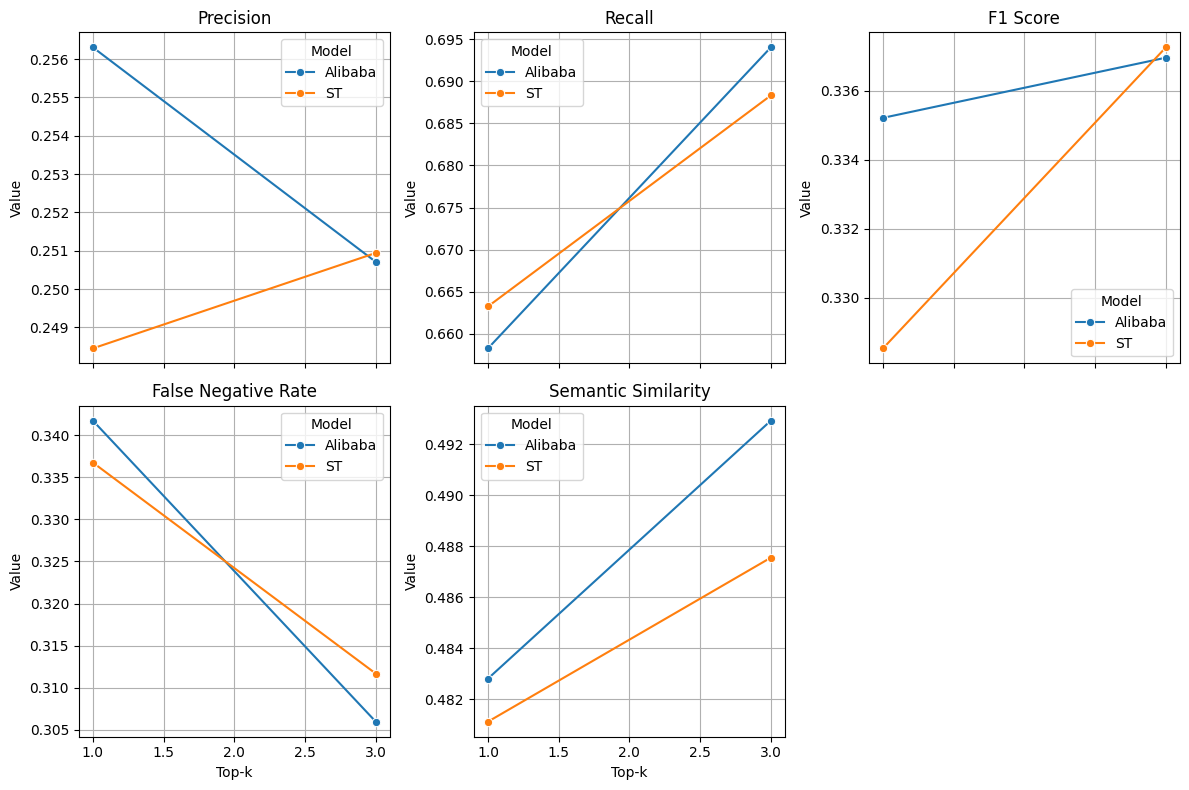

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ["Precision", 'Recall', 'F1 Score', 'False Negative Rate', 'Semantic Similarity']

fig, axes = plt.subplots(2, 3, figsize=(12, 8),  sharex=True, constrained_layout=True)

axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.lineplot(
        data=df, x='Top-k', y=metric, hue='Model', marker='o', ax=axes[i], ci=None
    )
    axes[i].set_title(metric)
    axes[i].set_ylabel("Value")
    axes[i].set_xlabel("Top-k")

    axes[i].grid(True)
    
axes[-1].set_visible(False)

plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Increase vertical and horizontal spacing
plt.tight_layout() 
plt.show()

In [104]:
grouped_df_category = df.groupby(['category'])[['Precision', "Recall", "F1 Score", "False Negative Rate", "Semantic Similarity"]].mean().reset_index()
grouped_df_category

,category,Precision,Recall,F1 Score,False Negative Rate,Semantic Similarity
0,Augment_Better,0.340502,0.705291,0.422443,0.294709,0.576602
1,Augment_Required,0.241225,0.560715,0.311222,0.439285,0.458609
2,LLM_Ready,0.189542,0.799094,0.283966,0.200906,0.449567
3,Temporal_Sensitive,0.304004,0.734018,0.406808,0.265982,0.532379
